In [3]:
######## Imports ########
#%matplotlib qt
import math
import numpy as np
import scipy.io
import os, sys
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from scipy.optimize import Bounds
import plotly.graph_objects as go
import pandas as pd
import random
mpl.rcParams['mathtext.default'] = 'regular'
print(mpl.matplotlib_fname())
plt.rcParams["axes.linewidth"] = 1.0
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/Users/aravind/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


# Read CytoSim trajectory

In [12]:
import subprocess
class replicate:
    ridx = 0;
    Nsnaps = 0;
    snap = [];
    timevector = []
    def __init__(self, rid):
        self.ridx = rid
        self.Nsnaps = 0
        self.snap = [];
        self.timevector =[];
    def addsnapshot(self):
        self.snap.append(snapshot(1))


class snapshot:
    sidx = 0;
    filcoord=[]
    crossboundcoord=[];
    crossboundblobid = [];
    crossboundfilid = [];
    solidcoord = [];
    shapevec = [];
    def __init__(self, sid):
        self.sidx = sid
        self.filcoord = [];
        self.crossboundcoord = [];
        self.crossboundblobid = [];
        self.crossboundfilid = [];
        self.solidcoord = [];
        self.shapevec = [];

def readcytosimtraj (*args):
    if(len(args)):
        filepath = args[0]
        filename = 'objects.cmo'
    else:
        filepath = '/Users/aravind/Research/PostDoc/Research/cytosimfiles/Fgrow_3_2/kon_1e-1_koff_1e+0/'
        filename = 'objects.cmo'

    # Get number of solids
    test = subprocess.run(["./get_nsolids.sh","-f", filepath],
                        capture_output=True)
    nsolids = int(test.stdout)
    r=[];
    Nruns =1 
    for  i in range(0,Nruns):
        r.append(replicate(i))
    printstatus = False;
    recordStatus = False;
    #filepath = '/Users/aravind/Research/PostDoc/Research/cytosimresults/sample_yossi/'
    #filename = 'objects.cmo'
    ridx = 0;
    sidx=-1;
    # Open file
    fptr = open(filepath+filename,'r')
    for line in fptr:
        if(printstatus):
            print(line)

        if('time' in line):
            t = float((line.split(' '))[1])
            r[ridx].timevector.append(t)
            r[ridx].addsnapshot();
            sidx = sidx + 1
            r[ridx].snap[sidx].solidcoord = [None]*nsolids

        elif('#section fiber' in line):
            fcoord=[];
            line = fptr.readline()
            if(printstatus):
                print(line)
            while(not('section' in line)):
                if(printstatus):
                    print(line)
                if('f2' in line):
                    recordStatus = False;
                if('f1' in line):
                    if(fcoord):
                        r[ridx].snap[sidx].filcoord.append(np.array(fcoord))
                        fcoord=[];
                    recordStatus = True;
                elif(' ' in line[0] and recordStatus):
                    line = line.strip()
                    cstring = line.split(' ')
                    fcoord.append([float(cstring[0]), float(cstring[1]), float(cstring[2])])
                line = fptr.readline()
            #when it exists, if fcoord has not been recorded, record it.
            if(fcoord):
                r[ridx].snap[sidx].filcoord.append(np.array(fcoord))
                fcoord=[];
        if('#section space' in line):
            line = fptr.readline()
            splitline = line.split()
            if('sphere' in line):
                temp = float(splitline[len(splitline)-1])
            else:
                temp = [float(splitline[2]),float(splitline[3]),float(splitline[4]),]
            r[ridx].snap[sidx].shapevec= temp
        # Bound crosslinker hands
        if('#section solid' in line):
            line = fptr.readline()
            while(not('section' in line)):
                if(printstatus):
                    print(line)
                #Get solid ID
                line = line.strip()
                cstring = line.split(' ')
                cstring = cstring[0].split(':')
                solidid = int(cstring[1])
                solidcoord = [];
                line = fptr.readline()
                while(line[0]!='d' and not('section' in line)):
                    #Get coord
                    line = line.strip()
                    cstring = line.split(' ')
                    solidcoord.append([float(cstring[0]), float(cstring[1]), float(cstring[2])])
                    line = fptr.readline()
                if(solidcoord):
                    r[ridx].snap[sidx].solidcoord[solidid-1] = np.array(solidcoord)
            
            # Bound crosslinker hands
            if('#section single A' in line):
                blobid = []
                line = fptr.readline()
                if(printstatus):
                    print(line)
                while(not('section' in line)):
                    if(printstatus):
                        print(line)
                    line = line.strip()
                    cstring = line.split()
                    r[ridx].snap[sidx].crossboundfilid.append(int(cstring[1][1:len(cstring[1])]))
                    r[ridx].snap[sidx].crossboundblobid.append(int(cstring[3][1:len(cstring[3])]))
                    line = fptr.readline()
    fptr.close()
    print('Number of snapshots='+str(len(r[ridx].snap)))
    fptr.close()
    return r

# Probability density vs radial distance

In [ ]:
# Get filaments
# Get beads
# calculate distance
# bin the distance
binedges = np.linspace(0,1.100,33)
nedges = np.shape(binedges)[0]
binaxis = 0.5*(binedges[0:nedges-1:1]+binedges[1:nedges:1])
histvec = np.zeros(np.shape(binaxis))
nr=1;nc=2;
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(7, 4), dpi=300, facecolor='w', edgecolor='k')
for ridx  in range(21,28):
    r = rlist10_3[ridx]
    SREF = len(r[0].snap)-5
    filcoord = r[0].snap[SREF].filcoord;
    for f, fc in enumerate(filcoord):
        Nbeads = np.shape(fc)[0]
        # Interpolate each monomer in the filament
        #interpcoord = interpolateallmonomers(fc)
        #Nbeads = (np.shape(interpcoord))[0]
        counter = 0
        dvec =[];
        for b in range(0,Nbeads):
            #bc = interpcoord[b,:]
            bc = fc[b,:]
            dvec.append(np.linalg.norm(bc))
        hhist, bin_edges = np.histogram(dvec,bins=binedges,density=False)
        histvec = histvec + hhist
    ax=axvec[0]
    yval=1-np.cumsum(histvec/np.sum(histvec))
    x=ax.plot(binaxis,yval)
    ax.set_xticks(np.arange(0,1.1,0.1))
    ax.set_xlim([0,1.03])
    print(yval)
print(binaxis)

# Snapshot printer

In [35]:
from os.path import exists
from skimage import data
from skimage import io
from skimage import transform
from skimage import color
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
##
import cv2
import glob
import re
from PIL import Image
# Before trying to stitch the snapshots, please generate them using Cytosim
# cd FOLDER-WITH-OBJECTS.CMO 
# run CYTOSIM-INSTALL-PATH/bin/play movie 
image_input_dir = 'PATH-TO-STORE-MOVIE-IN'
image_file_extension='png'
frame_rate = 30
##

plt.rcParams.update({'font.size': 30, 'font.family':'arial', 'font.weight':'normal'})
plt.rcParams["axes.linewidth"] = 1.0
#plt.rcParams.update({'font.family':'Arial'})
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    right=0.95,
                    bottom=0.5, 
                    top=0.95,
                    wspace=0.05, 
                    hspace=0.05)

[['R_6_r_0/' 'R_21_r_0/']
 ['R_6_r_1/' 'R_21_r_1/']
 ['R_6_r_2/' 'R_21_r_2/']
 ['R_6_r_3/' 'R_21_r_3/']
 ['R_6_r_4/' 'R_21_r_4/']
 ['R_6_r_5/' 'R_21_r_5/']]


/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_82329/1731770373.py:76: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 432x288 with 0 Axes>

# Snapshot printer Arp23 

In [473]:
nr = 1
nc = 8
decoratetag = 100
# trial 1 used experimental values of kbind
filepathv = 'PATH-TO-FOLDER/Arp23_concsweep_steric/'
videofilename = 'Arp23_concsweep_steric'
extratag ='/'
repid = 0
offset = 0
coloffset = 7
repid = 0
dirlist = []
for i in range(0,nr):
    dirrow = []
    for j in range(0,nc):
        Rval = j
        dirrow.append('R_'+str(Rval)+'_r_'+str(0)+'/')
    dirlist.append(dirrow)

# Create the transpose of the dirlist
#dirlist = np.array(dirlist).T
print(dirlist)
plt.subplots_adjust(left=0.1,
                    right=0.99,
                    bottom=0.0, 
                    top=0.99,
                    wspace=0.03, 
                    hspace=0.03)
extraspace = 0.25
extraspaceleft = 0.5;
filepath='';
dirname=''
ylabellist = ['','']
yaxislabel = ''
xlabellist = [0,10,25,50,75,100,125,150]
xaxislabel = '[Arp2/3] (nM)'
trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
            dirname,601,5,1.0,extratag,
            xlabellist, ylabellist, xaxislabel, yaxislabel)

[['R_0_r_0/', 'R_1_r_0/', 'R_2_r_0/', 'R_3_r_0/', 'R_4_r_0/', 'R_5_r_0/', 'R_6_r_0/', 'R_7_r_0/']]


<Figure size 432x288 with 0 Axes>

# Snapshot printer VCA

In [5]:
image_input_dir = 'PATH-TO-STORE-MOVIE-IN'
image_file_extension='png'
frame_rate = 30
nr = 5
nc = 8
decoratetag = 100
# trial 1 used experimental values of kbind
filepathv = 'PATH-TO-FOLDER/VCA_Arp23_concsweep_steric_kunbind_0/'
videofilename = 'VCA_Arp23_concsweep_steric_kunbind_0'
extratag ='/'
repid = 0
offset = 0
coloffset = 7
repid = 0
dirlist = []
for i in range(0,nc):
    dirrow = []
    for j in range(0,nr):
        Rval = nr*i+j
        dirrow.append('R_'+str(Rval)+'_r_'+str(0)+'/')
    dirlist.append(dirrow)
# Create the transpose of the dirlist
dirlist = np.array(dirlist).T
print(dirlist)
plt.subplots_adjust(left=0.1,
                    right=0.99,
                    bottom=0.0, 
                    top=0.99,
                    wspace=0.03, 
                    hspace=0.03)
extraspace = 0.25
extraspaceleft = 0.5;
filepath='';
dirname=''
ylabellist = ['0','1','2','5','10']
yaxislabel = r"[VCA] in $\mu M$"
xlabellist = [0,10,25,50,75,100,125,150]
xaxislabel = '[Arp2/3] (nM)'
trajplotter(image_input_dir+videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,
            dirname,601,5,1.0,extratag, 
            xlabellist, ylabellist, xaxislabel, yaxislabel)

[['R_0_r_0/' 'R_5_r_0/' 'R_10_r_0/' 'R_15_r_0/' 'R_20_r_0/' 'R_25_r_0/'
  'R_30_r_0/' 'R_35_r_0/']
 ['R_1_r_0/' 'R_6_r_0/' 'R_11_r_0/' 'R_16_r_0/' 'R_21_r_0/' 'R_26_r_0/'
  'R_31_r_0/' 'R_36_r_0/']
 ['R_2_r_0/' 'R_7_r_0/' 'R_12_r_0/' 'R_17_r_0/' 'R_22_r_0/' 'R_27_r_0/'
  'R_32_r_0/' 'R_37_r_0/']
 ['R_3_r_0/' 'R_8_r_0/' 'R_13_r_0/' 'R_18_r_0/' 'R_23_r_0/' 'R_28_r_0/'
  'R_33_r_0/' 'R_38_r_0/']
 ['R_4_r_0/' 'R_9_r_0/' 'R_14_r_0/' 'R_19_r_0/' 'R_24_r_0/' 'R_29_r_0/'
  'R_34_r_0/' 'R_39_r_0/']]


/var/folders/qm/v0zzfl5x2dj52xwyvq0k2n2c0000gn/T/ipykernel_4971/3563108022.py:90: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


<Figure size 432x288 with 0 Axes>

# SNAPSHOT PRINTER FUNCTION

In [4]:
from os.path import exists
from skimage import data
from skimage import io
from skimage import transform
from skimage import color
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
##
import cv2
import glob
import re
from PIL import Image
def trajplotter(videofilename, decoratetag,dirlist,nr,nc,filepathv,filepath,dirname,Nsnaps,deltasnap,panelsize,extratag, xlabellist, ylabellist,*args):
    plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight':'normal'})
    extension = ".ppm"
    img_array = []
    scalefactor = 1
    plt.subplots_adjust(left=0.1,
                        right=0.99,
                        bottom=0.9, 
                        top=0.99,
                        wspace=0.02/scalefactor, 
                        hspace=0.02/scalefactor)
    extraspace = 0.3
    extraspaceleft = 0
    length = panelsize*nc+extraspaceleft/scalefactor
    width = panelsize*(nr+extraspace*2)/scalefactor
    ################
    for snaps in range(0,Nsnaps,deltasnap):
        #print(snaps)
        fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(length, width), dpi=300, facecolor='w', edgecolor='k')
        if decoratetag ==24:
            line = plt.Line2D([0.08,0.9],[0.375,0.375], transform=fig.transFigure, color="black")
            fig.add_artist(line)
            line = plt.Line2D([0.08,0.9],[0.63,0.63], transform=fig.transFigure, color="black")
            fig.add_artist(line)
        if(nr==1):
            axvec=np.reshape(axvec, (1,nc))
        for r in range(0,nr):
            ylabelcounter = 0
            for c in range(0,nc):
                plotrow = nr-r-1;
                ax=axvec[plotrow][c]
                dirname = dirlist[r][c]
                if(len(dirname)==0):
                    ax.set_visible(False)
                    continue;
                else:
                    ylabelcounter = ylabelcounter + 1
                    
                fvar = filepathv+dirname+extratag+'/'+"movie"+ f'{snaps:04d}'+extension
                if(decoratetag==16):
                    fvar =  filepathv+dirname+'/'+"movie"+ f'{snapvec[c]:04d}'+extension
                if decoratetag == 2:
                    if 'v4' in dirname:
                        dirname = dirname[0:8]+'_koff_1e-1'
                        fvar = filepath+dirname+'/'+"movie"+ f'{snaps:04d}'+extension
                    else:
                        dirname = dirname.replace('-v','/v')
                        fvar = filepathv+dirname+'/'+"movie"+ f'{snaps:04d}'+extension
                if decoratetag ==3:
                    if 'kon' not in dirname:
                        fvar = filepathv+'/intermediate/'+dirname+'/'+"movie"+ f'{snaps:04d}'+extension

                # read an image
                if exists(fvar):
                    img = io.imread(fvar)
                    #img_half = transform.rescale(img, scale=0.5, multichannel=True)
                    ax.imshow(img)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.set_axis_off
                    if r==0:
                        ax.set_xlabel(xlabellist[c])
                    if ylabelcounter == 1:
                        ax.set_ylabel(ylabellist[r])
                    if(len(args)==3):
                        ax.set_title(args[2][r][c])
                else:
                    print('Not found: '+fvar)
        if(len(args)==0):
            plt.text(0.0, 0.14, r'$k_{bind} (s^{-1})$', transform=plt.gcf().transFigure, rotation=90)
            plt.text(0.12, 0.03, r"$k_{unbind} (s^{-1})$", transform=plt.gcf().transFigure)
        else:
            plt.text(0.07, 0.14, args[1], transform=plt.gcf().transFigure, rotation=90)
            plt.text(0.1, 0.07, args[0], transform=plt.gcf().transFigure)
            # plt.text(0.0, 0.14, args[1], transform=plt.gcf().transFigure, rotation=90)
            # plt.text(0.12, 0.1, args[0], transform=plt.gcf().transFigure)

        plt.tight_layout()
        ##
        fig.canvas.draw()
        # img = Image.frombytes('RGB', 
        # fig.canvas.get_width_height(),fig.canvas.tostring_rgb())

        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,)).copy()
        img.setflags(write=1)
        # red and blue channels need to be swapped
        red = img[:,:,2].copy()
        blue = img[:,:,0].copy()
        img[:,:,2] = blue
        img[:,:,0] = red
        # ax=axvec[0][1];
        # ax.imshow(img)
        newsize = fig.canvas.get_width_height()
        #img = cv2.resize(np.float32(img), tuple(newsize), interpolation = cv2.INTER_AREA)
        img_array.append(img)
        ##
        if(snaps>=Nsnaps-deltasnap or snaps==600 or snaps==560):
        #if(snaps%100 ==0):
            plt.savefig(videofilename+'_'+f'{snaps:04d}'+'.png', dpi=300, bbox_inches='tight')
            # plt.savefig(videofilename+f'{snaps:04d}'+'.svg', bbox_inches='tight')
            # plt.savefig(videofilename+f'{snaps:04d}'+'.eps', bbox_inches='tight')
            plt.savefig(videofilename+'_'+f'{snaps:04d}'+'.pdf', bbox_inches='tight')
        plt.close()

    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    out = cv2.VideoWriter(videofilename+'.mov',fourcc,20,newsize)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

# CytoSim script writer

# CytoSim Arp2/3 script writer

In [161]:
sourcefilepath = 'PATH-TO-FOLDER/template_Arp/'
servervar = 'cerebroarp'
# STERIC
stericflag = True
stericKvec = [1]
time_step = 0.001
shapestring = ["sphere"]
radiusstring = [1.0]
flength = [2*np.pi] #microns per fil
flength = [0.1] #microns per fil
# GROWTH
activitytag = 'grow'
growingspeedvec = [[0.0103, 0]]
totaltime = 600
Nfil = [30]
gorwingforcevec = [[10.0]]

################## VASP parameters
bindingrate = [1e+0]
bind_dist = [0.03]
unbindingrate = [1e+0]
unbindingforce = [10.0]
Nblob = [1000]
##################
blobsizevec = [0.03]
valency = [4]
nsteps = int(totaltime/time_step)
nframes = totaltime
replicates = 5
rigidityvec = [0.075]
total_polymer = 5*2*np.pi*np.array(Nfil)*radiusstring[0]

#################
arpbindingrate = [0.5]
CArp = np.array([0,10,25,50,75,100,125,150])
Narp = (CArp*(4/3)*1e-15*np.pi*1e-9*scipy.constants.Avogadro).astype(int)
print(Narp)
##################
jobfoldername = 'Arp23_concsweep_steric'

[  0  25  63 126 189 252 315 378]


# VCA job file

In [69]:
sourcefilepath = 'PATH-TO-FOLDER/template_Arp/'
servervar = 'cerebrovcaarp'
# STERIC
stericflag = True
stericKvec = [1]
time_step = 0.001
shapestring = ["sphere"]
radiusstring = [1.0]
flength = [2*np.pi] #microns per fil
flength = [0.1] #microns per fil
# GROWTH
activitytag = 'grow'
growingspeedvec = [[0.0103, 0]]
totaltime = 600
Nfil = [30]
gorwingforcevec = [[10.0]]
################## VASP parameters
bindingrate = [1e+0]
bind_dist = [0.03]
unbindingrate = [1e+0]
unbindingforce = [10.0]
Nblob = [1000]
##################
blobsizevec = [0.03]
valency = [4]
nsteps = int(totaltime/time_step)
nframes = totaltime
replicates = 5
rigidityvec = [0.075]
total_polymer = 5*2*np.pi*np.array(Nfil)*radiusstring[0]
#################
arpbindingrate = [0.5]
CArp = np.array([0,10,25,50,75,100,125,150])
Narp = (CArp*(4/3)*1e-15*np.pi*1e-9*scipy.constants.Avogadro).astype(int)
print(Narp)
##################
vca_growingspeedvec=np.multiply([3.44],[0,2522,2*2522,5*2522,10*2522]);
vca_growingOFFspeedvec=np.multiply([-2.7],[0,2522,2*2522,5*2522,10*2522]);
vca_max_lengthvec=np.multiply([0.0027*5],[0,2522,2*2522,5*2522,10*2522]);
jobfoldername = 'VCA_Arp23_concsweep_steric'
VCAFLAG=True;
### Kundind 0 
vca_growingOFFspeedvec=[0,0,0,0,0];
jobfoldername = 'VCA_Arp23_concsweep_steric_kunbind_0'

[  0  25  63 126 189 252 315 378]


# Arp2/3 script code

In [70]:
#Read template file
# Open file in read mode
frptr = open(sourcefilepath+'config0.cym','r')
# Read all lines
Lines = frptr.readlines()
frptr.close()
# CHANGE HAS BEEN MADE. THIS FUNCTION
# WILL PRINT LINES A TO B IN EXQCTLY
# INCLUDING LINES A AND B.
# LINE NUMBERS START AT 1 IN THE INPUT
def writeline(fptr, Lines, start, end):
    for iter in range(start-1,end):
        fptr.write(Lines[iter])

if(not stericflag):
    stericKvec = []

totalnumberfiles = len(arpbindingrate)*len(Narp)*len(shapestring)*len(radiusstring)*len(growingspeedvec)*len(gorwingforcevec)*len(bindingrate)*len(bind_dist)*len(unbindingrate)*len(unbindingforce)*len(blobsizevec)*len(Nfil)*len(Nblob)*len(valency)*len(rigidityvec)
if(len(stericKvec)):
    totalnumberfiles=len(stericKvec)*totalnumberfiles

if(VCAFLAG):
    totalnumberfiles = len(vca_growingspeedvec)*totalnumberfiles
    
print('Total number of jobs='+str(totalnumberfiles))
filepath = '/Users/aravind/Research/PostDoc/Research/CytoSim/'+jobfoldername+'/'
os.mkdir(filepath)
#read the file
stericKiter = 0
shapeiter = 0
riter = 0
gspeediter = 0
#sspeediter = 0
gforceiter = 0
binditer = 0
bdistiter = 0
unbinditer = 0
unbindfiter = 0
Nfiliter = 0
Nblobiter = 0
blobsizeiter = 0
valiter = 0
rigidityiter =0
Narpiter = 0
arpbinditer = 0
Nvcaiter = 0;
reffilename ='reference.txt'
frefptr = open(filepath+reffilename,'w')
jobfilename = 'submitjobs.sh'
fjobptr = open(filepath+jobfilename,'w')
jobfilename_rest = 'submitjobs_2.sh'
fjobptr_rest = open(filepath+jobfilename_rest,'w')
frefptr.write('REPLICATE |FNAME     ');
if(len(stericKvec)):
    frefptr.write('|STERICK   ')
frefptr.write('|SHAPE     |RADIUS    |RIGIDITY  |GSPEED    |SSPEED    |GFORCE    |KON       |BDIST     |KOFF      |KOFF_F    |NFIL      |NBLOB     |ARPKON    |BLOBSIZE  |VALENCY   |NARP      |\n')
reftextwidth = 10
for iter in range(0,totalnumberfiles):
    print([shapeiter, riter, gspeediter, gforceiter, binditer, bdistiter, unbinditer, unbindfiter, Nfiliter, Nblobiter, valiter])
    filename = 'config'+str(iter)+'.cym'
    for repcounter in range(0,replicates):
        foldername = 'R_'+str(iter)+'_r_'+str(repcounter)
        installfolder = '~/cytosim-stable-edited/bin/sim '
        if(repcounter==0):
            fjobptr.write('cd '+foldername+'; nohup '+installfolder+filename+'>nohup.out& cd ..;'+'\n')
        else:
            fjobptr_rest.write('cd '+foldername+'; nohup '+installfolder+filename+'>nohup.out& cd ..;'+'\n')

        rstring = str(repcounter)
        reftext = rstring.ljust(reftextwidth, ' ')+'|';
        reftext = reftext + foldername.ljust(reftextwidth, ' ')+'|';

        os.mkdir(filepath+foldername)

        if servervar == 'tscc':
            jobfolderpathtscc = '/oasis/tscc/scratch/achandrasekaran/'+jobfoldername+'/'
            writejobfile(filepath, foldername, installfolder, iter, jobfolderpathtscc)

        foutptr = open(filepath+'/'+foldername+'/'+filename,'w')
        writeline(foutptr, Lines, 1, 10)
        foutptr.write('    time_step = '+str(time_step)+'\n')
        writeline(foutptr, Lines, 12, 12)

        if(stericKiter < len(stericKvec)):
            stericK = str(stericKvec[stericKiter])
            reftext = reftext + stericK.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    steric = 1, '+stericK+'\n')

        writeline(foutptr, Lines, 14, 18)
        if shapeiter < len(shapestring):
            shape = shapestring[shapeiter]
            reftext = reftext + shape.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    shape = '+shape+'\n')

        writeline(foutptr, Lines, 20, 23)

        if riter < len(radiusstring):
            radius = str(radiusstring[riter])
            reftext = reftext + radius.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    radius ='+radius+'\n')

        writeline(foutptr, Lines, 25, 28)

        if rigidityiter < len(rigidityvec):
            rigidity = str(rigidityvec[rigidityiter])
            reftext = reftext + rigidity.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    rigidity = '+rigidity+'\n')

        writeline(foutptr, Lines, 30, 32)

        foutptr.write('    activity ='+activitytag+'\n')

        if gspeediter < len(growingspeedvec):
            gs =''
            for giter, g in enumerate(growingspeedvec[gspeediter]):
                if(giter>0):
                    gs = gs + ", "
                gs = gs + str(g)
            reftext = reftext + gs.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    growing_speed = '+gs+'\n')
        
        #Write shrinking rates if it is in treadmilling 
        if(('treadmill' in activitytag or 'realtreadmill' in activitytag) and gspeediter < len(shrinkingspeedvec)):
            ss =''
            for siter, s in enumerate(shrinkingspeedvec[gspeediter]):
                if(siter>0):
                    ss = ss + ", "
                ss = ss + str(s)
            reftext = reftext + ss.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    growing_off_speed = '+ss+'\n')
        else:
            foutptr.write('    growing_off_speed = 0, 0'+'\n')

        if gforceiter < len(gorwingforcevec):
            gf = ''
            frontstring = '';
            if 'treadmill' in activitytag:
                frontstring = '%'
            for giter, g in enumerate(gorwingforcevec[gforceiter]):
                if(giter>0):
                    gf = gf + ", "
                gf = gf + str(g)
            reftext = reftext + gf.ljust(reftextwidth, ' ')+'|'
            foutptr.write(frontstring+'    growing_force = '+gf+'\n')
        
        if 'realtreadmill' in activitytag or total_polymer>0:
            foutptr.write('    total_polymer = '+str(total_polymer[Nfiliter])+'\n')

        foutptr.write('    max_length = '+str(2*np.pi*radiusstring[riter])+'\n')
        
        if(stericKiter < len(stericKvec)):
            foutptr.write('    steric = 1, 0.0035'+'\n')
        
        foutptr.write('    binding_key = 1'+'\n')

        writeline(foutptr, Lines, 39, 43)

        #Binding rate and distance    
        if binditer < len(bindingrate):
            kon = str(bindingrate[binditer])
            reftext = reftext + kon.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    binding = '+kon+', ')
        if bdistiter < len(bind_dist):
            bd = str(bind_dist[bdistiter])
            reftext = reftext + bd.ljust(reftextwidth, ' ')+'|'
            foutptr.write(bd+'\n')

        writeline(foutptr, Lines, 45, 45)
        #Unbinding rate and force
        if unbinditer < len(unbindingrate):
            ubr = str(unbindingrate[unbinditer])
            reftext = reftext + ubr.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    unbinding = '+ubr+', ')    
        if unbindfiter < len(unbindingforce):
            ubf = str(unbindingforce[unbindfiter])
            reftext = reftext + ubf.ljust(reftextwidth, ' ')+'|'
            foutptr.write(ubf+'\n')
        
        foutptr.write('    binding_key = 1'+'\n')
        
        writeline(foutptr, Lines, 47, 56)

        #Nfil
        if(Nfiliter < len(Nfil)):
            nf = str(Nfil[Nfiliter])
            reftext = reftext + nf.ljust(reftextwidth, ' ')+'|'
            foutptr.write('new '+nf+' filament'+'\n')

        writeline(foutptr, Lines, 58, 58)
        if len(flength) == 1:
            foutptr.write('    length = '+str(flength[0])+'\n')
        else:
            foutptr.write('    length = '+str(flength[Nfiliter])+'\n')
        
        if('grow' in activitytag):
            foutptr.write('    end_state = 1, 0'+'\n')

        if('treadmill' in activitytag or 'realtreadmill' in activitytag):
            # Growing plus end and shrinking minus end
            foutptr.write('    end_state = 1, 4'+'\n')

        writeline(foutptr, Lines, 60, 65)

        if(stericKiter<len(stericKvec)):
            foutptr.write('    steric = 1'+'\n')

        # Arp2/3 section
        writeline(foutptr, Lines, 67, 72)
        #Arp2/3 binding rate
        if(arpbinditer<len(arpbindingrate)):
            ab = str(arpbindingrate[arpbinditer])
            reftext = reftext + ab.ljust(reftextwidth, ' ')+'|'
            foutptr.write('    binding = '+ab+', 0.012'+'\n')

        writeline(foutptr, Lines, 74, 75)
        foutptr.write('    binding_key = 1'+'\n')
        writeline(foutptr, Lines, 76, 109)
        #Nblob 
        if(Nblobiter < len(Nblob)):
            nb = str(Nblob[Nblobiter])
            reftext = reftext + nb.ljust(reftextwidth, ' ')+'|'
            foutptr.write('new '+nb+' blob'+'\n')

        writeline(foutptr, Lines,111, 112)
        foutptr.write('    separation = '+str(0.9*2*blobsizevec[blobsizeiter])+'\n')

        writeline(foutptr, Lines, 114, 115)
        #Valency
        foutptr.write('    sphere1 = 0 0 0, '+str(blobsizevec[blobsizeiter])+', ')
        bsize = str(blobsizevec[blobsizeiter])
        reftext = reftext + bsize.ljust(reftextwidth, ' ')+'|'
        if valiter < len(valency):
            vs = str(valency[valiter])
            reftext = reftext + vs.ljust(reftextwidth, ' ')+'|'
            for v in range(0,valency[valiter]):
                foutptr.write('1 graftedcrosslinker')
                if(v<valency[valiter]-1):
                    foutptr.write(', ')
                else:
                    foutptr.write('\n')
            
        writeline(foutptr, Lines, 117, 118)

        if(Narpiter < len(Narp)):
            narp = str(Narp[Narpiter])
            reftext = reftext + narp.ljust(reftextwidth, ' ')+'|'
            foutptr.write('new '+narp+' arp23'+'\n')

        # VCA section
        if VCAFLAG:
            foutptr.write('set fiber vca'+'\n')
            foutptr.write('{'+'\n')
            foutptr.write('    rigidity = 0.00001'+'\n')
            foutptr.write('    segmentation = 0.1'+'\n')
            foutptr.write('    confine = inside, 200, cell'+'\n')
            foutptr.write('    display = ( line=5, 0; color=0x5CBA47FF; )'+'\n')
            foutptr.write('    activity =grow'+'\n')
            foutptr.write('    growing_speed = '+str(vca_growingspeedvec[Nvcaiter])+', 0'+'\n')
            foutptr.write('    growing_off_speed = '+str(vca_growingOFFspeedvec[Nvcaiter])+', 0'+'\n')
            foutptr.write('    growing_force = inf'+'\n')
            if 'realtreadmill' in activitytag or total_polymer>0:
                foutptr.write('    total_polymer = '+str(total_polymer[Nfiliter])+'\n')
            foutptr.write('    max_length = '+str(vca_max_lengthvec[Nvcaiter])+'\n')
            foutptr.write('    min_length = 0.0027'+'\n')
            foutptr.write('    steric = 0'+'\n')
            foutptr.write('    binding_key = 2'+'\n')
            foutptr.write('}'+'\n')
            if vca_growingspeedvec[Nvcaiter]>0:
                foutptr.write('new 1 vca'+'\n')
            else:
                foutptr.write('new 0 vca'+'\n')
            foutptr.write('{'+'\n')
            foutptr.write('    length = 0.1'+'\n')
            foutptr.write('    end_state = 1, 0'+'\n')
            foutptr.write('}'+'\n')
        ################################################################################
        writeline(foutptr, Lines, 120, 120)
        foutptr.write('run '+ str(nsteps) +' system \n')
        foutptr.write('{' +'\n')
        foutptr.write('    nb_frames = '+ str(nframes) +'\n')

        writeline(foutptr, Lines, 124, 125)

        foutptr.write('}' +'\n')
        foutptr.close()
        print(reftext)
        frefptr.write(reftext+'\n')
    if(VCAFLAG):
        Nvcaiter = Nvcaiter + 1;
        if(Nvcaiter>=len(vca_growingspeedvec)):
            Narpiter = Narpiter + 1
            Nvcaiter = 0;
    else:
        Narpiter = Narpiter + 1
    # Update other iterators
    if(Narpiter>=len(Narp)):
        valiter = valiter + 1
        Narpiter = 0
    if(valiter>=len(valency)):
        blobsizeiter = blobsizeiter + 1
        valiter = 0
    if(blobsizeiter>=len(blobsizevec)):
        Nfiliter = Nfiliter + 1
        blobsizeiter = 0
    if Nfiliter>=len(Nfil):
        arpbinditer = arpbinditer + 1
        Nfiliter = 0
    if arpbinditer>=len(arpbindingrate):
        Nblobiter = Nblobiter + 1
        Nfiliter = 0
    if Nblobiter >=len(Nblob):
        unbindfiter = unbindfiter + 1
        Nblobiter = 0
    if(unbindfiter >= len(unbindingforce)):
        unbinditer = unbinditer + 1
        unbindfiter = 0
    if(unbinditer>=len(unbindingrate)):
        bdistiter = bdistiter + 1
        unbinditer = 0
    if(bdistiter >= len(bind_dist)): 
        binditer = binditer + 1
        bdistiter = 0
    if(binditer >= len(bindingrate)):
        gforceiter = gforceiter + 1
        binditer = 0 
    if(gforceiter >= len(gorwingforcevec)):
        # sspeediter = sspeediter + 1
        gforceiter = 0
    # if(sspeediter >= len(shrinkingspeedvec)):
        gspeediter = gspeediter + 1
    #     sspeediter = 0
    if(gspeediter >= len(growingspeedvec)):
        rigidityiter = rigidityiter + 1
        gspeediter = 0
    if(rigidityiter >= len(rigidityvec)):
        riter = riter + 1
        rigidityiter = 0;
    if(riter >= len(radiusstring)):
        shapeiter = shapeiter + 1
        riter = 0
    if(shapeiter >= len(shapestring)):
        stericKiter = stericKiter + 1
        shapeiter = 0
    riter = 0
frefptr.close()
fjobptr.close()
fjobptr_rest.close()

Total number of jobs=40
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0         |R_0_r_0   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |1.0       |10.0      |30        |0.5       |1000      |0.03      |4         |0         |
1         |R_0_r_1   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |1.0       |10.0      |30        |0.5       |1000      |0.03      |4         |0         |
2         |R_0_r_2   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |1.0       |10.0      |30        |0.5       |1000      |0.03      |4         |0         |
3         |R_0_r_3   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |1.0       |10.0      |30        |0.5       |1000      |0.03      |4         |0         |
4         |R_0_r_4   |1         |sphere    |1.0       |0.075     |0.0103, 0 |10.0      |1.0       |0.03      |1.0       |10.0      |30        |0.5

# Use ODE model similar to CytoSim to get the parameters

(30, 942.4777960769379, [0.0103, 0], [0, 0])
[170.89451798762576, 188.49555921538757]
0.2529291627376613
0.0


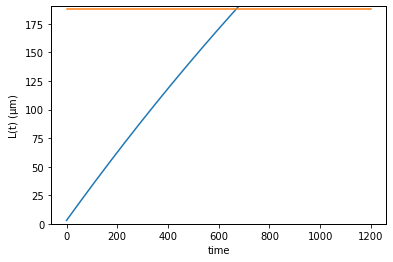

Treadmilling rate = 0.0074$\mu m/fil.s$


In [161]:
from scipy.integrate import odeint

# function that returns dy/dt
def model(L,t, Nfil, TFactin, growkinetics, shrinkkinetics):
    #Nfil = tparams[0]
    #TFactin = tparams[1]
    #growkinetics = tparams[2]
    kgrowplus = growkinetics[0]
    kgrowminus = growkinetics[1]
    #shrinkkinetics = tparams[3]
    kshrinkplus = shrinkkinetics[0]
    kshrinkminus = shrinkkinetics[1]
    dPdt = Nfil*(kgrowplus*(1-L[0]/TFactin) + kshrinkplus)
    dMdt = Nfil*(kgrowminus*(1-L[0]/TFactin) + kshrinkminus)
    dLdt = dPdt + dMdt
    return np.array([dLdt,dPdt,dMdt])
############### PARAMETERS TO GET 2*pi*R with TOTAL POLYMER
Nfil = 30
Lmax = 2*np.pi*Nfil
TFactin = 10*np.pi*Nfil
kgrowplus = 0.0103#microns/s
kshrinkplus = 0
kshrinkminus = 0
kgrowminus = 0
################
print((Nfil, TFactin, [kgrowplus,kgrowminus],[kshrinkplus, kshrinkminus]))
# initial condition
L0 = 0.1*Nfil

# time points
t = np.linspace(0,1200,1200)

# solve ODE
y = odeint(model,np.array([L0,0,0]),t, args = (Nfil, TFactin, [kgrowplus,kgrowminus],[kshrinkplus, kshrinkminus]))

# plot results
plt.plot(t,y[:,0])
#plt.plot(np.diff(y[:,2]))
print([y[600,0],Lmax])
dt = np.diff(t)
dPdt = np.diff(y[:,1])/dt
dMdt = np.diff(y[:,2])/dt
print(dPdt[600])
print(dMdt[600])
plt.xlabel('time')
plt.ylabel(r"L(t) $(\mu m)$")
plt.ylim([0,1.01*Lmax])
plt.plot([0,1200],[Lmax,Lmax])
plt.xticks([0,200,400,600,800,1000,1200])
plt.show()
print('Treadmilling rate = ' +str(round(dPdt[1000]/Nfil,4))+ r'$\mu m/fil.s$')

# ODE model with VCA

[1.         0.96444951 0.82224753 0.75160997 0.75134536]


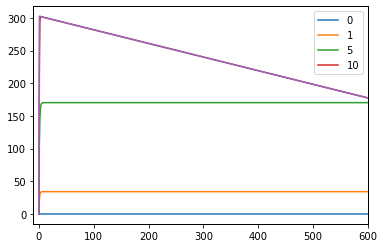

In [19]:
from scipy.integrate import odeint

# function that returns dy/dt
def model_VCA(L,t, Nfil , TFactin, growkinetics, shrinkkinetics, vcakinetics):
    #Nfil = tparams[0]
    #TFactin = tparams[1]
    #growkinetics = tparams[2]
    kgrowplus = growkinetics[0]
    kgrowminus = growkinetics[1]
    #shrinkkinetics = tparams[3]
    kshrinkplus = shrinkkinetics[0]
    kshrinkminus = shrinkkinetics[1]

    kbind = vcakinetics[0];
    kunbind = vcakinetics[1];
    # L[0] is Factin 
    used_polymer = L[0] + L[4]
    free_polymer = 1- used_polymer/TFactin
    dPdt = Nfil*(kgrowplus*free_polymer + kshrinkplus)
    dMdt = Nfil*(kgrowminus*free_polymer + kshrinkminus)
    # Actin consumed by VCA
    Nvca_free = L[1];
    Nvca_bound = L[4];
    #DNvca_boundt = kbind*Nvca_free*free_polymer - kunbind*Nvca_bound
    DNvca_boundt = (kbind*free_polymer - kunbind)*Nvca_free
    Lmax = Nvca_free*0.0027*5
    if(L[4]+DNvca_boundt >= Lmax):
        DNvca_boundt = Lmax-L[4];
    if(L[4]+DNvca_boundt<0):
        DNvca_boundt = 0;
    # Free VCA
    DNvca_freedt = -DNvca_boundt
    DNvca_freedt = 0;
    dLdt = dPdt + dMdt
    return np.array([dLdt,DNvca_freedt,dPdt,dMdt,DNvca_boundt])

#parameters when Lfil = 2 pi R
############### PARAMETERS TO GET 2*pi*R with TOTAL POLYMER
Nfil = 30
Lmax = 2*np.pi*Nfil
TFactin = 10*np.pi*Nfil
kgrowplus = 0.0103#microns/s
kshrinkplus = 0
kshrinkminus = 0
kgrowminus = 0
kbind = 0.002# mum/s
kunbind =0 # mum/s
################
# initial condition
L0 = 0.1*Nfil

# time points
t = np.linspace(0,1200,1200)
L600vec = [];
kbindvec = np.logspace(3,10,10)
# kbindvec = [0.6]
# kbindvec = [0.5]
for Nvca_free in [0,2522,5*2522,10*2522,20*2522]:
    kbindvec = [2.96];
    kunbind = 2.0;
    for kbind in kbindvec:
        # solve ODE
        Nvca_bound = 0;
        y = odeint(model_VCA,np.array([L0,Nvca_free,0,0,Nvca_bound]),t, args = (Nfil, TFactin, [kgrowplus,kgrowminus],[kshrinkplus, kshrinkminus], [kbind, kunbind]))
        L600vec.append(y[600,0]);
        plt.plot(t,y[:,4])
        # plt.plot(t,y[:,4]/(Nvca_free))
        # print(y[:,4]/(Nvca_free))
        plt.xlim([-10,600])
plt.legend([0,1,5,10])
print(L600vec/L600vec[0])

# Find the kbind that takes away 1muM F-actin at 1muM vca

0.03614022406938923
[3.44, 0.0]
[3.44, 0.03554997407151683]
[3.44, 0.07109994445363776]
[3.44, 0.12662977104514617]
[3.44, 0.13015502197680584]


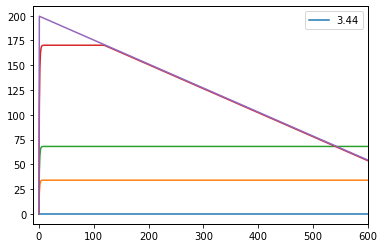

In [392]:
t = np.linspace(0,600,601)
L600vec = [];
kbindvec = np.logspace(np.log10(2.947),np.log10(4.7),10)
kbindvec = np.logspace(-3,2,10)
kbindvec=[3.44];
target = 1/27.67;
print(target)
no_vca_len = 170.76791677894465;
for Nvca_free in [0, 1*2522, 2*2522, 5*2522, 10*2522]:
    kunbind = 2.7
    for kbind in kbindvec:
        # solve ODE
        Nvca_bound = 0;
        y = odeint(model_VCA,np.array([L0,Nvca_free,0,0,Nvca_bound]),t, args = (Nfil, TFactin, [kgrowplus,kgrowminus],[kshrinkplus, kshrinkminus], [kbind, kunbind]))
        L600vec.append(y[600,0]);
        plt.plot(t,y[:,4])
        plt.xlim([-10,600])
        print([kbind, 1-L600vec[-1]/no_vca_len])
plt.legend(kbindvec)

# Radial density function

In [ ]:
def interpolateallmonomers (fc):
    interpcoord = []
    Nbeads = (np.shape(fc))[0]
    interpcoords = []
    for i in range(0,Nbeads-1):
        cyl1 = fc[i,:]
        cyl2 = fc[i+1,:]
        cyllength = np.linalg.norm(cyl2-cyl1)
        nmonomers = int(np.ceil(cyllength/2.7e-3))
        #Add minus end
        interpcoords.append(cyl1)
        # Add rest of the monomers
        for mid in range(1,nmonomers-1):
            alpha = mid/nmonomers
            tmp = cyl1*(1-alpha) + alpha*cyl2
            interpcoords.append(tmp)
        #Add plus end
        interpcoords.append(cyl2)
    return np.array(interpcoords)

def getradialdensitysnap(filcoord, Radialbinvec, histcountsvec):
    for f, fc in enumerate(filcoord):
        # Interpolate each monomer in the filament
        interpcoord = interpolateallmonomers(fc)
        #interpcoord = fc
        Nbeads = (np.shape(interpcoord))[0]
        # Distance of each point from the center
        normvec = np.linalg.norm(interpcoord,axis=1)

        hist, bin_edges  = np.histogram(normvec,bins=Radialbinvec,density=False)
        histcountsvec = histcountsvec + hist
    return histcountsvec

def getradialdensity(rset, deltasnap, N, Rval, outputfile):
    r =  rset[0]
    Nsnaps = len(r.snap)
    if deltasnap>1:
        Ndatapoints = int(Nsnaps/deltasnap)+1
    else:
        Ndatapoints = int(Nsnaps)
    # Row represents data 
    datamatrix = np.zeros((5,Ndatapoints))
    datamatrix[0][:] = np.arange(0,Nsnaps,deltasnap)
    densitydf = pd.DataFrame()
    Radialbinvec = np.linspace(0,1,41)
    Radialbincenter = Radialbinvec[0:len(Radialbinvec)-1]+(Radialbinvec[1]-Radialbinvec[0])
    densitydf["Radius"] = Radialbincenter
    scounter = 0
    for SREF in range(0,Nsnaps,deltasnap):
        densitysnap = np.zeros(len(Radialbinvec)-1)
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Snap ="+str(SREF)+" Current Time =", current_time, flush=True)
        Nfilsnap = []
        L = []
        for runidx in range(0,len(rset)):
            nsnaplocal = len(rset[runidx].snap)
            # Check if current run has the SREF'th snap. If so, collect data, if not, move on.
            if(SREF<=nsnaplocal):
                filcoord = np.array(rset[runidx].snap[SREF].filcoord)
                densitysnap = getradialdensitysnap(filcoord,Radialbinvec,densitysnap)
        densitydf[SREF] = densitysnap
    #WRITE DATA TO FILE
    print('Saving in file named '+outputfile,flush=True)
    #Nfpc = Number of filaments per crosslinker∂∂
    densitydf.to_csv(outputfile)

def frontend_density_Rval_repid(N, Rval, repid, *args):
    # For example Arp23_concsweep_steric
    foldername = args[0]
    # args[1] gives path to Arp23_concsweep_steric
    fpathvar = args[1]+'/'+foldername+'/'  
    # output file name
    outputfile = args[1]+'PATH-TO/PLOTCSVFILES/Density_'+foldername+'R_'+str(Rval)+'_r_'+str(repid)+'.csv'
    print(foldername, flush=True)
    rset = []
    dirname = 'R_'+str(Rval)+'_r_'+str(repid)
    print('Reading trajectory '+dirname,flush=True)
    r = readcytosimtraj(fpathvar+dirname+'/','filonly')
    print('Trajectory read..',flush=True)
    rset.append(r[0])
    print('Read repid '+str(repid),flush=True)
    getradialdensity(rset, 1, N, Rval,outputfile)
    print("The End....", flush=True)

# job files to get radial density both Arp2/3 and VASP runs

In [ ]:
cytosimfolder = 'Arp23_concsweep_steric'
cytosimresultspath = 'PATH-TO-DIR'
N=1;
for Rval in range(0,8):
    for repid in range(0,5):
        frontend_density_Rval_repid(N, Rval, repid, cytosimfolder, cytosimresultspath)

cytosimfolder = 'VCA_Arp23_concsweep_steric_kunbind_0'
cytosimresultspath = 'PATH-TO-DIR'
N=1;
for Rval in range(0,40):
    for repid in range(0,3):
        frontend_density_Rval_repid(N, Rval, repid, cytosimfolder, cytosimresultspath)

# FILAMENT LENGTH AND NUMBER

In [ ]:
def frontend_filprops_Rval(N, Rval, Nreps, *args):
    foldername = args[0]
    fpathvar = args[1]+'/'+foldername+'/'  
    outputfile = args[1]+'outputfiles/Fillength_'+foldername+'R_'+str(Rval)+'.csv'
    outputfile2 = args[1]+'outputfiles/Fillength_dist_'+foldername+'R_'+str(Rval)+'.csv'
    print(foldername, flush=True)
    rset = []
    for repid in range(0,Nreps):
        dirname = 'R_'+str(Rval)+'_r_'+str(repid)
        print('Reading trajectory '+dirname,flush=True)
        r = readcytosimtraj(fpathvar+dirname+'/','filonly')
        print('Trajectory read..',flush=True)
        rset.append(r[0])
        print('Read repid '+str(repid),flush=True)
    getfillengthprops(rset, 1, N, Rval,outputfile, outputfile2)
    print("The End....", flush=True)

def getfillengthprops(rset, deltasnap, N, Rval, outputfile,outputfile2):
    print(np.shape(rset))
    r =  rset[0]
    Nsnaps = len(r.snap)
    if deltasnap>1:
        Ndatapoints = int(Nsnaps/deltasnap)+1
    else:
        Ndatapoints = int(Nsnaps)
    datamatrix = np.zeros((7,Ndatapoints))
    datamatrix[0][:] = np.arange(0,Nsnaps,deltasnap)
    scounter = 0
    movsnapcounter =0
    Lmatrix = []
    for SREF in range(0,Nsnaps,deltasnap):
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Snap ="+str(SREF)+" Current Time =", current_time, flush=True)
        Nfilsnap = []
        L = []
        Lsum = []

        for runidx in range(0,len(rset)):
            Lsum_r = 0
            nsnaplocal = len(rset[runidx].snap)
            # Check if current run has the SREF'th snap. If so, collect data, if not, move on.
            if(SREF<nsnaplocal):
                filcoord = np.array(rset[runidx].snap[SREF].filcoord)
                Nfilsnap.append(len(filcoord))
                for f, fc in enumerate(filcoord):
                    Lfil_r = getfillength(fc)
                    Lsum_r = Lsum_r + Lfil_r
                    L.append(Lfil_r)
            Lsum.append(np.sum(Lsum_r))
        Lmatrix.append(L)
        datamatrix[1][scounter]= np.mean(Nfilsnap)
        datamatrix[2][scounter]= np.std(Nfilsnap)
        datamatrix[3][scounter]= np.mean(L)
        datamatrix[4][scounter]= np.std(L)
        datamatrix[5][scounter]= np.mean(Lsum)
        datamatrix[6][scounter]= np.std(Lsum)
        scounter = scounter + 1 
        
    #WRITE DATA TO FILE
    print('Saving in file named '+outputfile,flush=True)
    #Nfpc = Number of filaments per crosslinker∂∂
    pd.DataFrame(datamatrix, index=['Time', 'Nfil_mean','Nfil_std','Lfil_mean','Lfil_std',
                                    'Lsum_mean','Lsum_std']).to_csv(outputfile)
    # Calculate moving average
    MOVAVGSCOUNTER = 0
    MOVAVG_NSNAPS = 5
    scounter = 0
    # This matrix will hold the PDF fillength
    #6 bins - 1micron, 12bins = 0.5, 24 - 0.25, 48,0.125
    fillen_bin_edges = np.linspace(0,6.5,100)
    #print(fillen_bin_edges)
    datamatrix2 = np.zeros((Ndatapoints,len(fillen_bin_edges)-1))
    for SREF in range(0,Nsnaps,deltasnap):
        minsnap = np.max([0,SREF-MOVAVG_NSNAPS])
        maxsnap = np.min([Nsnaps,SREF+MOVAVG_NSNAPS])
        Ltemp = []
        for MSREF in range(minsnap,maxsnap):
            Ltemp = Ltemp + Lmatrix[MSREF]
        pdfvec, bins = np.histogram(Ltemp,bins=fillen_bin_edges,density=True)
        datamatrix2[scounter][:] = pdfvec
        scounter = scounter + 1
    pd.DataFrame(datamatrix2, index=np.arange(0,Nsnaps,deltasnap)).to_csv(outputfile2)

# Job files to compute filament length and number as time profiles.

In [ ]:
cytosimfolder = 'Arp23_concsweep_steric'
cytosimresultspath = 'PATH-TO-DIR'
N=1;
for Rval in range(0,8):
        frontend_filprops_Rval(N, Rval, 5, cytosimfolder, cytosimresultspath)

cytosimfolder = 'VCA_Arp23_concsweep_steric_kunbind_0'
cytosimresultspath = 'PATH-TO-DIR'
N=1;
Nreps = 3;
for Rval in range(0,40):
        frontend_filprops_Rval(N, Rval, Nreps, cytosimfolder, cytosimresultspath)

## Arp23 flength plot

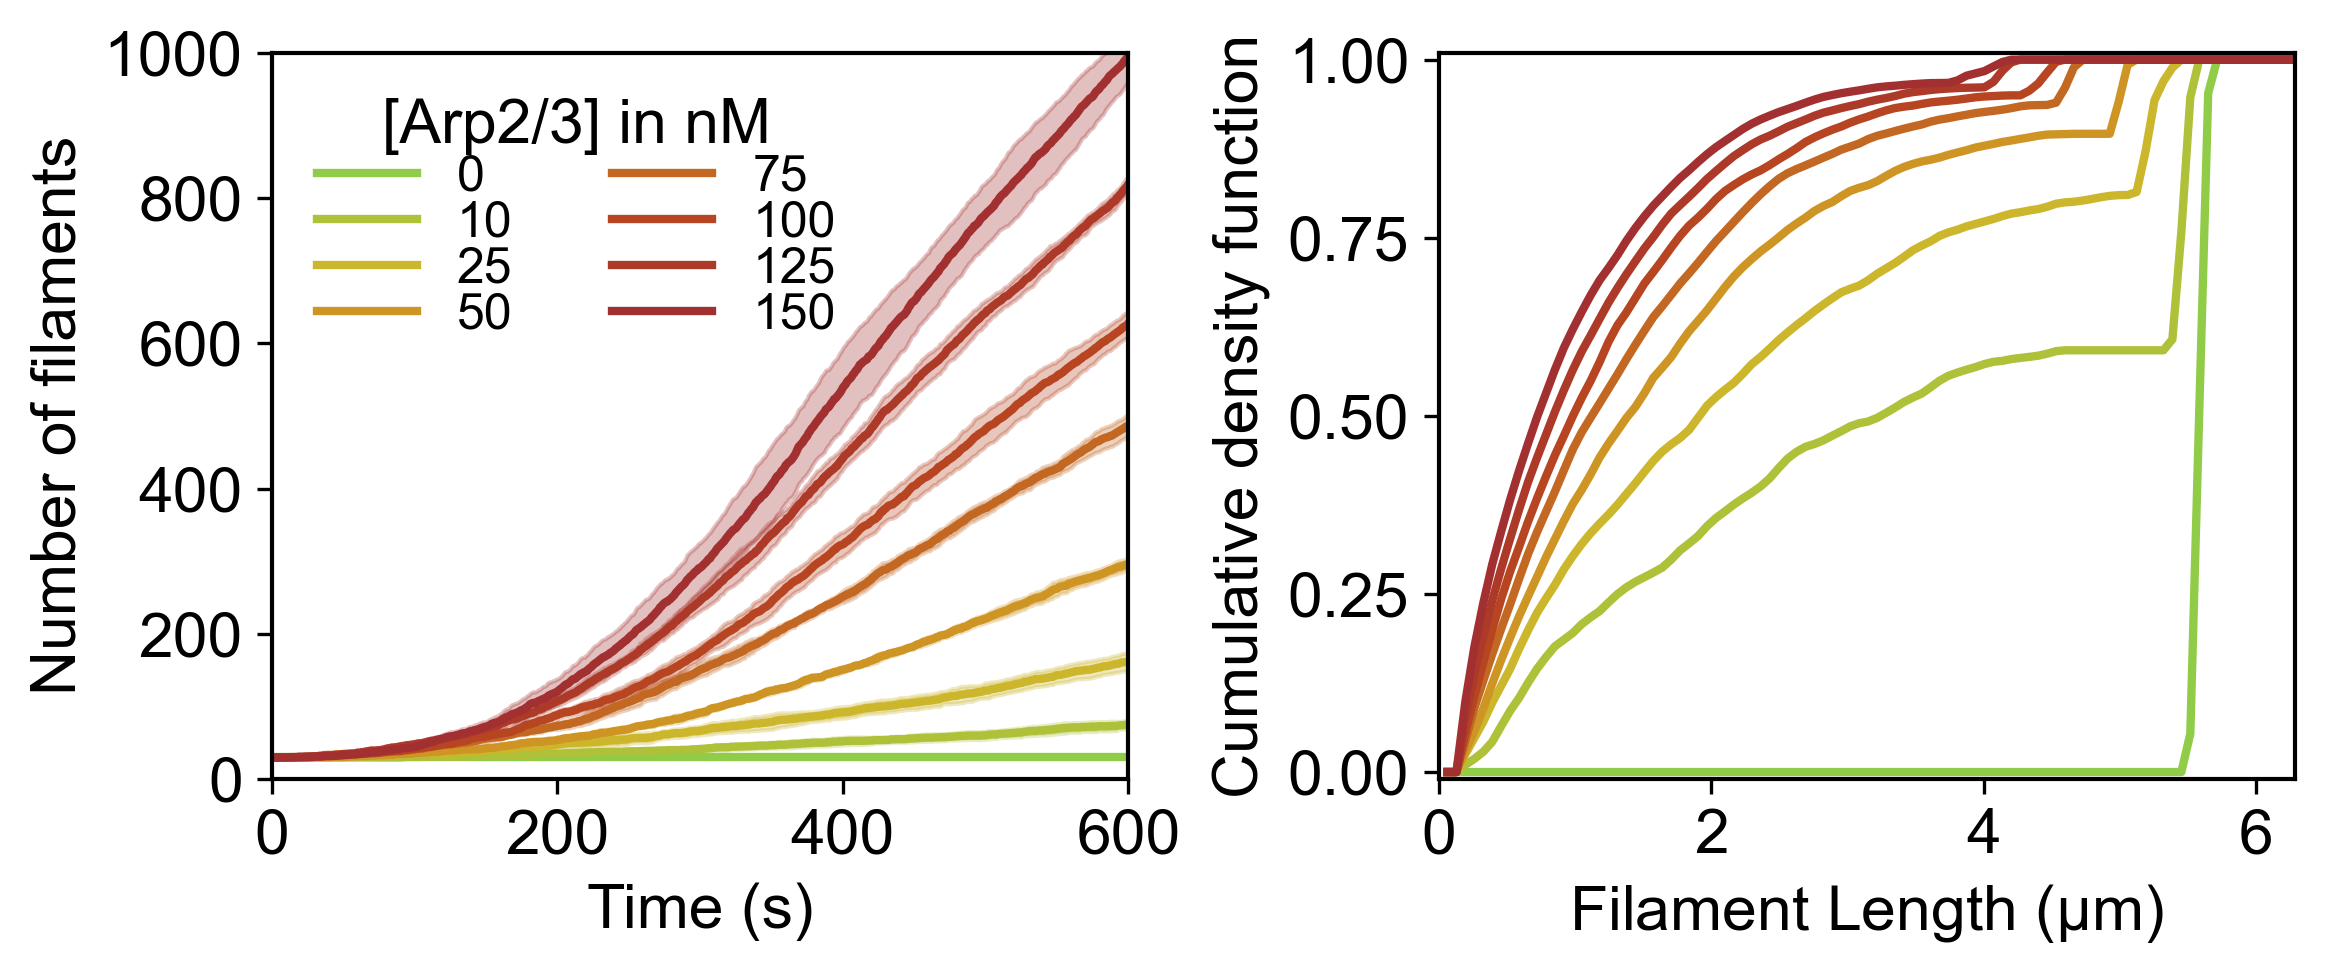

In [83]:
def converttocdf(X,PX):
    cdf = np.zeros(len(X))
    for iter, xval in enumerate(X):
        cdf[iter]=np.trapz(PX[0:iter],x=X[0:iter])
    return cdf/cdf[-1]
filereadpath = 'PATH-TO-/PLOTCSVFILES'
colorlist = ['#5fb549','#7ea124','#938c02','#a07500','#a75e0e','#a84621','#a22f31']
rgba = new_cmap(np.linspace(0, int(256/7), 256))
repid = 0
# Dataframe
# 0 time
#1 Mean N fil
#2 STD N fil
#3 MEAN L 
#4 STD L
plt.rcParams.update({'font.size': 15, 'font.family':'arial', 'font.weight':'normal'})
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
titlevec=['Arp2/3]=0nM',10,25,50,75,100,125,150]
# Get figure
nr = 1; nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(8,3.5), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.05,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.2, 
                    hspace=0.15)
legcell=[]
legcell2=[]
for i in range(0,8):
    Row1=[]
    fvar = filereadpath+'Fillength_Arp23_concsweep_stericR_'+str(i)+'.csv'
    df = pd.read_csv(fvar,index_col=0).transpose()
    legax=axvec[0].plot(df['Time'],df['Nfil_mean'],linewidth=2,color=rgba[i,:])
    axvec[0].fill_between(df['Time'],df['Nfil_mean']-df['Nfil_std'],df['Nfil_mean']+df['Nfil_std'],color=rgba[i,:],alpha=0.3)
    legcell.append(legax[0])
    axvec[0].legend(legcell,[0,10,25,50,75,100,125,150],ncol=2, title='[Arp2/3] in nM',frameon=False,fontsize=12, labelspacing=0)
    # legax=axvec[1].plot(df['Time'],df['Lfil_mean'],linewidth=2,color=rgba[i,:])
    # axvec[1].fill_between(df['Time'],df['Lfil_mean']-df['Lfil_std'],df['Lfil_mean']+df['Lfil_std'],color=rgba[i,:],alpha=0.3)
    # legcell2.append(legax[0])
axvec[0].set_xlabel('Time (s)')
axvec[0].set_ylabel('Number of filaments')
axvec[0].set_xlim([0,600])
axvec[0].set_ylim([0,1000])
for i in range(0,8):
    Row1=[]
    fvar = filereadpath+'Fillength_dist_Arp23_concsweep_stericR_'+str(i)+'.csv'
    df = pd.read_csv(fvar,index_col=0).transpose()
    X=np.linspace(0,6.5,100)
    X=np.array(X[0:len(X)-1])+np.array(X[1]-X[0])
    cdfvec = converttocdf(X,df[595])
    legax=axvec[1].plot(X,cdfvec,linewidth=2,color=rgba[i,:])
axvec[1].set_ylim([-0.01,1.01])
axvec[1].set_xlim([0,2*np.pi])
axvec[1].set_xlabel(r"Filament Length ($\mu m$)")
axvec[1].set_ylabel('Cumulative density function')
fig.tight_layout()
plt.savefig('Arp23_filstats.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Arp23_filstats.pdf', bbox_inches='tight')

# VCA filament length

      Time  Nfil_mean  Nfil_std  Lfil_mean  Lfil_std   Lsum_mean  Lsum_std
598  598.0       30.0       0.0   5.508989  0.001324  165.269667  0.006068
599  599.0       30.0       0.0   5.517211  0.001329  165.516337  0.006045
600  600.0       30.0       0.0   5.525431  0.001326  165.762928  0.005935
-----
      Time  Nfil_mean  Nfil_std  Lfil_mean  Lfil_std   Lsum_mean  Lsum_std
598  598.0       30.0       0.0   5.312057  0.001617  159.361719  0.008226
599  599.0       30.0       0.0   5.319982  0.001618  159.599466  0.008193
600  600.0       30.0       0.0   5.327903  0.001621  159.837078  0.008171
-----
      Time  Nfil_mean  Nfil_std  Lfil_mean  Lfil_std   Lsum_mean  Lsum_std
598  598.0       30.0       0.0   5.115912  0.001129  153.477353  0.001705
599  599.0       30.0       0.0   5.123543  0.001133  153.706282  0.001763
600  600.0       30.0       0.0   5.131171  0.001135  153.935132  0.001861
-----
      Time  Nfil_mean  Nfil_std  Lfil_mean  Lfil_std   Lsum_mean  Lsum_std
598  59

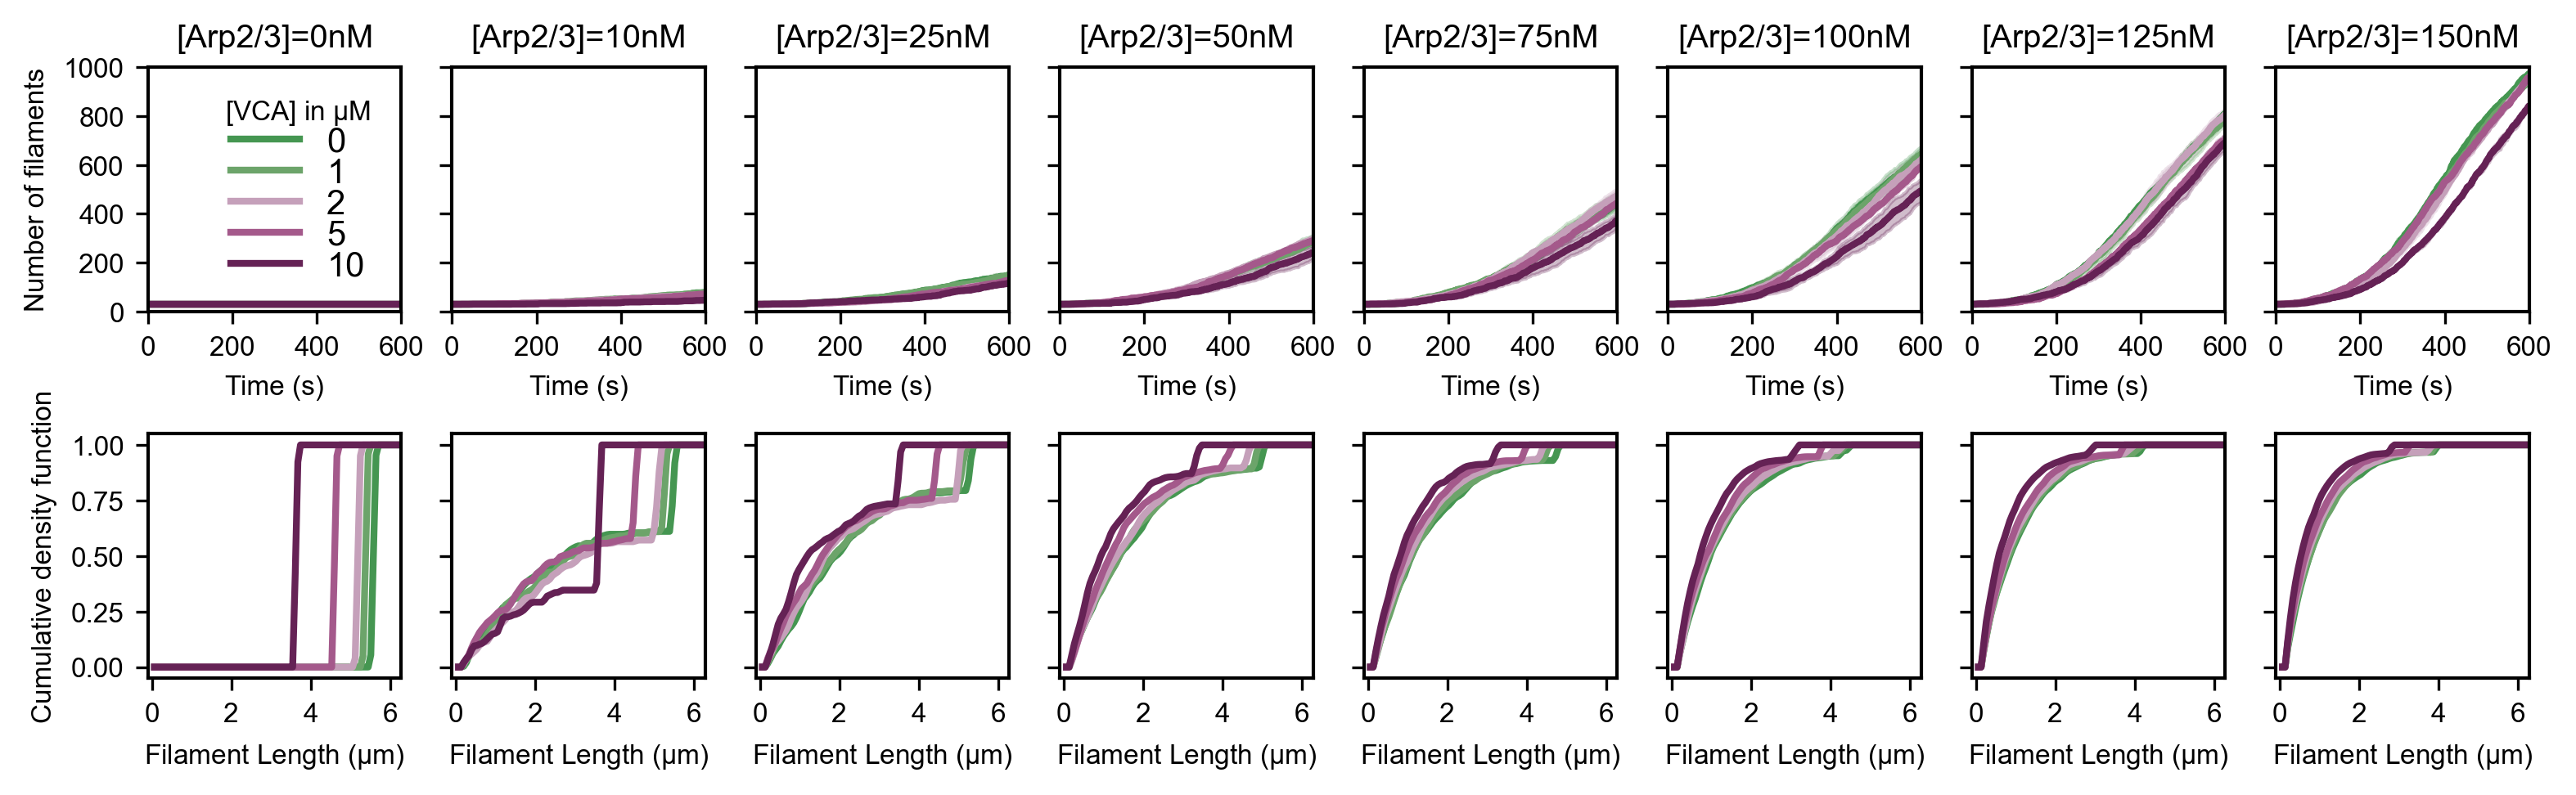

In [111]:
def converttocdf(X,PX):
    cdf = np.zeros(len(X))
    for iter, xval in enumerate(X):
        cdf[iter]=np.trapz(PX[0:iter],x=X[0:iter])
    return cdf/cdf[-1]
filereadpath = 'PATH-TO-/PLOTCSVFILES'
colorlist = ['#459651','#6CA46A','#C5A0BA','#A4598B','#652255']
repid = 0
# Dataframe
# 0 time
#1 Mean N fil
#2 STD N fil
#3 MEAN L 
#4 STD L
plt.rcParams.update({'font.size': 8, 'font.family':'arial', 'font.weight':'normal'})
new_cmap = mpl.colors.LinearSegmentedColormap.from_list("", ['#90CC47','#D7B226','#BA4820',"#a22f31"])
titlevec=['Arp2/3]=0nM',10,25,50,75,100,125,150]
arpvec =[0,10,25,50,75,100,125,150]
# Get figure
nr = 2; nc = 8
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(10,3.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.01,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.2, 
                    hspace=0.5)
legcell=[]
legcell2=[]
for plotidx in range(0,nc):
    for i in range(0,5):
        Rval = plotidx*5 + i
        Row1=[]
        fvar = filereadpath+'Fillength_VCA_Arp23_concsweep_steric_kunbind_0R_'+str(Rval)+'.csv'
        df = pd.read_csv(fvar,index_col=0).transpose()
        legax=axvec[0][plotidx].plot(df['Time'],df['Nfil_mean'],linewidth=2,color=colorlist[i])
        axvec[0][plotidx].fill_between(df['Time'],df['Nfil_mean']-df['Nfil_std'],df['Nfil_mean']+df['Nfil_std'],color=colorlist[i],alpha=0.3)
        legcell.append(legax[0])
        print(df[df['Time']>=598])
        print('-----')
        # legax=axvec[1].plot(df['Time'],df['Lfil_mean'],linewidth=2,color=rgba[i,:])
        # axvec[1].fill_between(df['Time'],df['Lfil_mean']-df['Lfil_std'],df['Lfil_mean']+df['Lfil_std'],color=rgba[i,:],alpha=0.3)
        # legcell2.append(legax[0])
    axvec[0][plotidx].set_xlabel('Time (s)')
    axvec[0][plotidx].set_xlim([0,600])
    axvec[0][plotidx].set_ylim([0,1000])
    axvec[0][plotidx].set_yticks([0,200,400,600,800,1000])
    axvec[0][plotidx].set_xticks([0,200,400,600])
    axvec[0][plotidx].set_title('[Arp2/3]='+str(arpvec[plotidx])+'nM')
    if plotidx>0:
        axvec[0][plotidx].set_yticklabels([])  
axvec[0][0].set_ylabel('Number of filaments')
axvec[0][0].legend(legcell,[0,1,2,5,10],ncol=1, title=r'[VCA] in $\mu$M',frameon=False,fontsize=10, labelspacing=0)
for plotidx in range(0,nc):
    for i in range(0,5):
        Rval = plotidx*5 + i
        Row1=[]
        fvar = filereadpath+'Fillength_dist_VCA_Arp23_concsweep_steric_kunbind_0R_'+str(Rval)+'.csv'
        df = pd.read_csv(fvar,index_col=0).transpose()
        X=np.linspace(0,6.5,100)
        X=np.array(X[0:len(X)-1])+np.array(X[1]-X[0])
        cdfvec = converttocdf(X,df[595])
        test_list = list(abs(cdfvec-0.5))
        minpos = np.where(test_list == np.min(test_list))[0]
        print(X[minpos[0]])
        legax=axvec[1][plotidx].plot(X,cdfvec,linewidth=2,color=colorlist[i])
    #axvec[1][plotidx].set_ylim([-0.01,1.01])
    axvec[1][plotidx].set_xlim([-0.1,2*np.pi])
    axvec[1][plotidx].set_xticks([0,2,4,6])
    axvec[1][plotidx].set_yticks([0,0.25,0.5,0.75,1.0])
    axvec[1][plotidx].set_xlabel(r"Filament Length ($\mu m$)")
    if plotidx>0:
        axvec[1][plotidx].set_yticklabels([])  
axvec[1][0].set_ylabel('Cumulative density function')
#fig.tight_layout()
plt.savefig('VCA_filstats.png', dpi=300, bbox_inches='tight')
fig.savefig( 'VCA_filstats.pdf', bbox_inches='tight')

## Arp23 radial density and filament length plots

[0.25, 0.925]


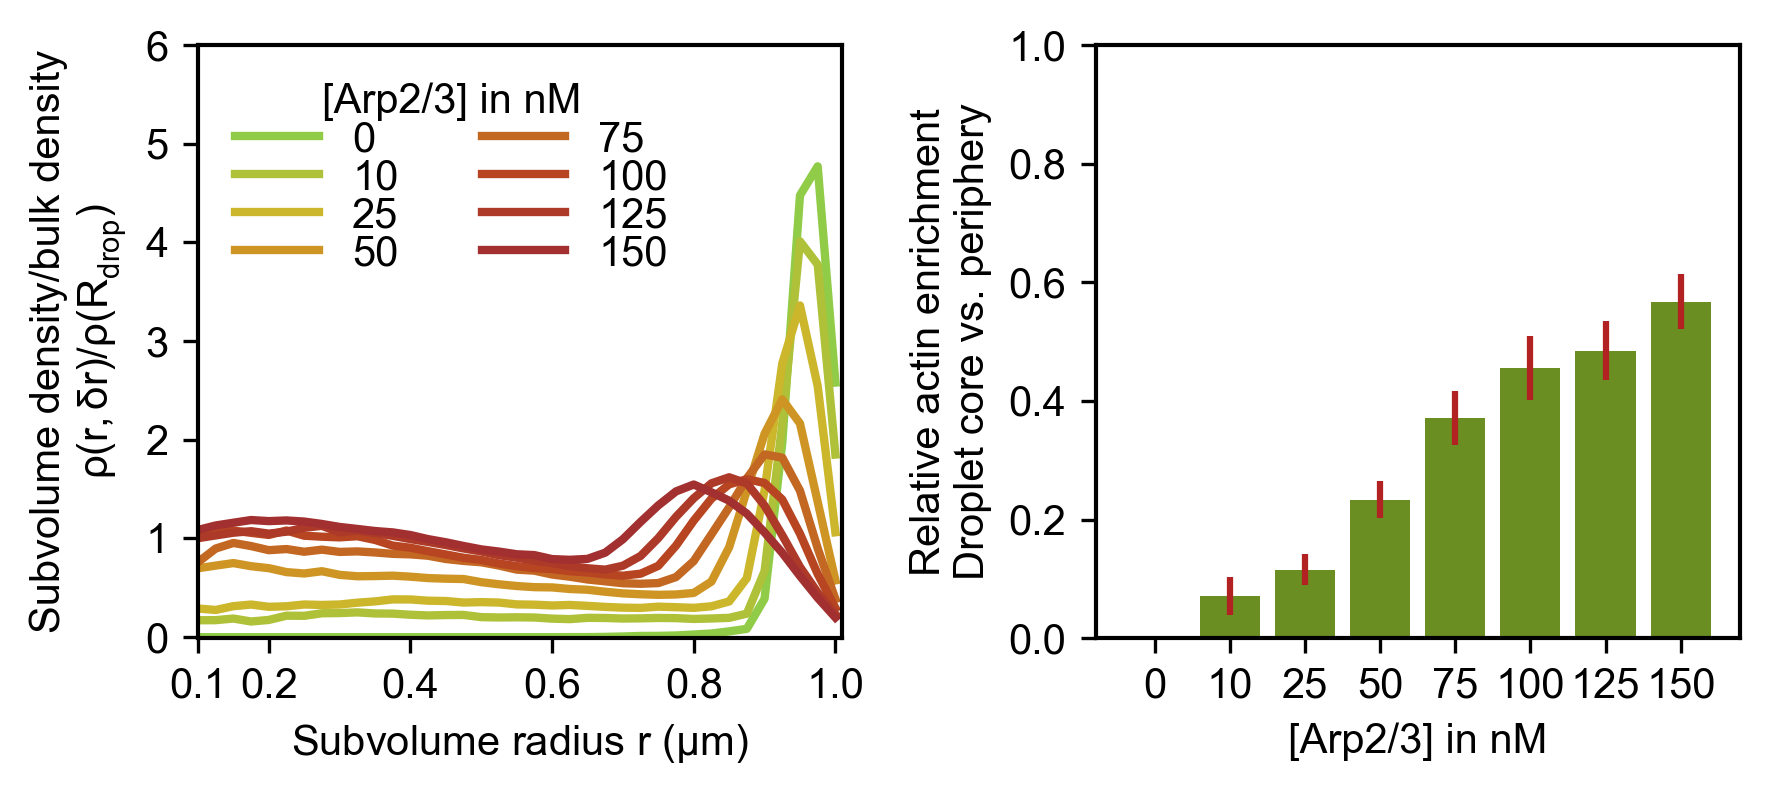

In [470]:
# Plot 1 - Just plot the final radial density
rgba = new_cmap(np.linspace(0, int(256/7), 256))
plt.rcParams.update({'font.size': 10, 'font.family':'arial', 'font.weight'
                    :'normal'})
filepath = 'PATH-TO-/PLOTCSVFILES'
nr = 1; nc = 2
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(6.0,2.75), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.25,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.25, 
                    hspace=0.15)
Nreps =5
legcell = []
plotdf2 = pd.DataFrame()
for Rval in range(0,8):
    Nveclist = []
    core_density_list = []
    peri_density_list = []
    relative_enrichment = []
    for repid in range(0,Nreps):
        filename = 'Density_Arp23_concsweep_stericR_'+str(Rval)+'_r_'+str(repid)+'.csv'
        fvar = filepath + filename
        df = pd.read_csv(fvar,index_col=0)
        Nframes = len(df.columns)
        #get the radius vector
        radvec = df["Radius"]
        radvec = pd.concat([pd.Series([0]), radvec])
        dR = radvec.iat[1]-radvec.iat[0]
        for SREF in range(Nframes-10,Nframes):
            #Get the number count vector
            Nbin = df.iloc[:,SREF]
            ######### ORIGINAL VERSION
            # core_pos = int(len(Nbin)/4-1)
            # core_radius = radvec[core_pos]
            # core_density = Nbin[core_pos]/(core_radius*core_radius)
            # peri_pos = int(len(Nbin)-4)
            # peri_radius = radvec[peri_pos]
            # peri_density = Nbin[peri_pos]/(peri_radius*peri_radius)
            # core_density_list.append(core_density)
            # peri_density_list.append(peri_density)
            # relative_enrichment.append(core_density/peri_density)
            #########
            #Nvec = np.cumsum(Nbin)
            Nvec = Nbin
            Nvec = pd.concat([pd.Series([0]), Nvec])
            localfactor =dR**-1*radvec**-2
            #Nmax = Nvec.iat[-1]
            Nmax = np.sum(Nvec)
            Rmax = radvec.iat[-1]
            bulkfactor = 3*Nmax/(Rmax*Rmax*Rmax)
            density_ratio = Nvec*localfactor/bulkfactor
            density_ratio = density_ratio.fillna(0)
            Nveclist.append(density_ratio)
            ################# UPDATED VERSION
            radvec_core = radvec[(radvec>=0.2) & (radvec<0.6)]
            Ncore = Nvec[(radvec>=0.2) & (radvec<0.6)]
            radvec_periphery = radvec[(radvec>=0.6)]
            Nperiphery = Nvec[(radvec>=0.6)]
            maxNcore = Ncore.max()
            maxrcore = radvec_core[Ncore.idxmax()]
            maxNperiphery = Nperiphery.max()
            maxrperiphery = radvec_periphery[Nperiphery.idxmax()]
            core_density = maxNcore/(maxrcore*maxrcore)
            peri_density = maxNperiphery/(maxrperiphery*maxrperiphery)
            core_density_list.append(core_density)
            peri_density_list.append(peri_density)
            relative_enrichment.append(core_density/peri_density)
            #################
    plotdf2[Rval] = [np.mean(relative_enrichment), np.std(relative_enrichment)]
    # N(r)/r^2/N(R)/R^2
    plotdf = pd.DataFrame({'Radius':radvec,
                        'Density ratio':np.mean(Nveclist, axis=0),
                        'Std':np.std(Nveclist,axis=0),
                        'SEM':np.std(Nveclist,axis=0)/np.sqrt(Nreps)})
   #print(plotdf)
    # for x in range(0,len(Nveclist)):
    #     axvec[0].plot(plotdf['Radius'],Nveclist[x],linewidth=0.5,color=rgba[Rval,:])
    legax = axvec[0].plot(plotdf['Radius'],plotdf['Density ratio'],linewidth=2,color=rgba[Rval,:])
    legcell.append(legax[0])
    # axvec[0].fill_between(plotdf['Radius'],
    #                    plotdf['Density ratio']-plotdf['Std'],
    #                    plotdf['Density ratio']+plotdf['Std'],color=rgba[Rval,:],alpha=0.3)
axvec[0].set_ylabel(r"Subvolume density/bulk density" "\n" r"$\rho(r, \delta r)/\rho(R_{drop})$")
axvec[0].set_xlabel(r"Subvolume radius r $(\mu m)$")
axvec[0].legend(legcell,[0,10,25,50,75,100,125,150],ncol=2, title='[Arp2/3] in nM',frameon=False,labelspacing=0)
axvec[0].set_xticks([0,0.1,0.2,0.4,0.6,0.8,1.0])
axvec[0].set_ylim([-0.01,6])
axvec[0].set_xlim([0.1,1.01])
##############
print([core_radius,peri_radius])
plotdf2 = plotdf2.T
plotdf2.columns = ['Mean','Std']
axvec[1].bar(np.arange(0,8),plotdf2['Mean'],color='olivedrab')
axvec[1].errorbar(np.arange(0,8),plotdf2['Mean'], yerr=plotdf2['Std'], fmt = 'o', markersize = 0, ecolor='firebrick')
axvec[1].set_xticks(np.arange(0,8))
axvec[1].set_xticklabels([0,10,25,50,75,100,125,150])
axvec[1].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
axvec[1].set_xlabel('[Arp2/3] in nM')
axvec[1].set_ylabel(r"Relative actin enrichment" "\n" "Droplet core vs. periphery")
fig.tight_layout()
plt.savefig('Arp23_density.png', dpi=300, bbox_inches='tight')
fig.savefig( 'Arp23_density.pdf', bbox_inches='tight')

# VCA Density plot

[0, 0]
[1, 0]
[2, 0]
[3, 0]
[4, 0]
[5, 1]
[6, 1]
[7, 1]
[8, 1]
[9, 1]
[10, 2]
[11, 2]
[12, 2]
[13, 2]
[14, 2]
[15, 3]
[16, 3]
[17, 3]
[18, 3]
[19, 3]
[20, 4]
[21, 4]
[22, 4]
[23, 4]
[24, 4]
[25, 5]
[26, 5]
[27, 5]
[28, 5]
[29, 5]
[30, 6]
[31, 6]
[32, 6]
[33, 6]
[34, 6]
[35, 7]
[36, 7]
[37, 7]
[38, 7]
[39, 7]


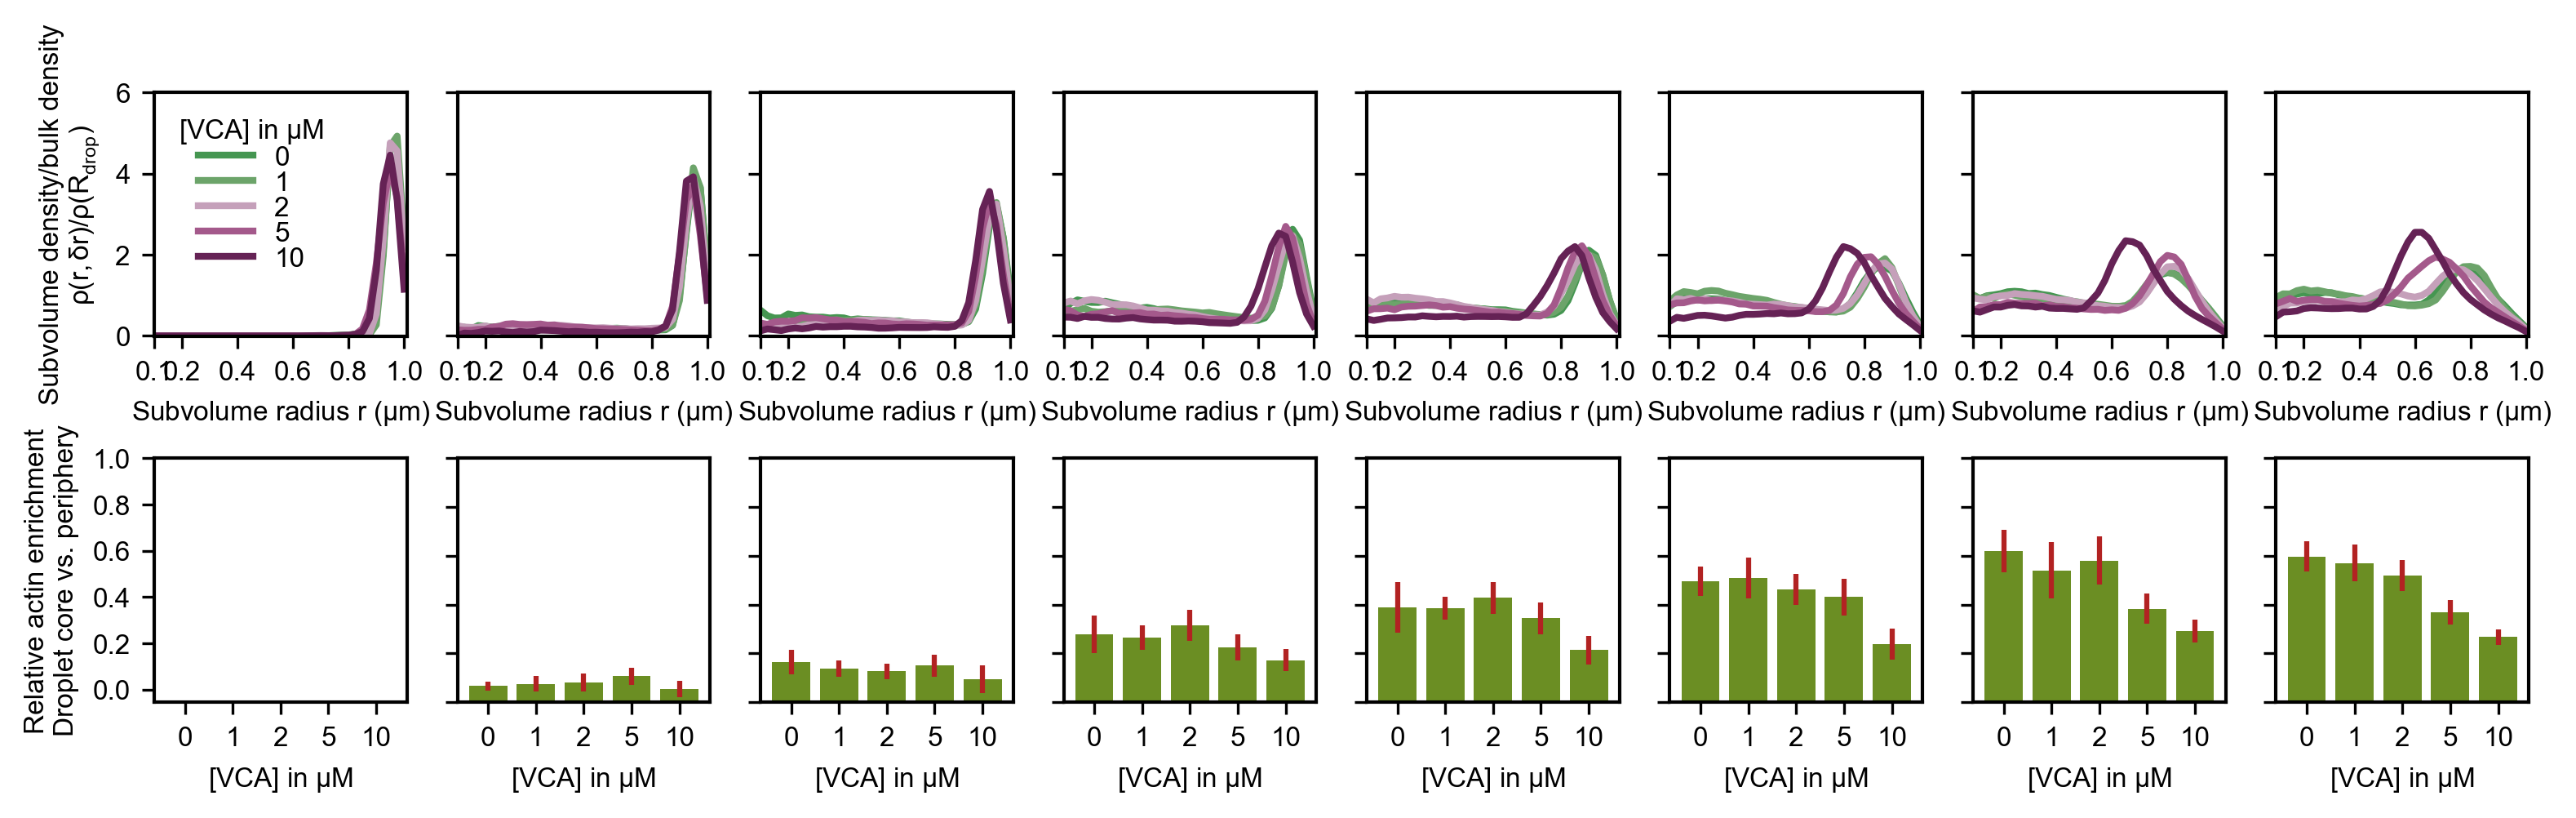

In [112]:
# Plot 1 - Just plot the final radial density
colorlist = ['#459651','#6CA46A','#C5A0BA','#A4598B','#652255']
rgba = new_cmap(np.linspace(0, int(256/7), 256))
plt.rcParams.update({'font.size': 8, 'font.family':'arial', 'font.weight'
                    :'normal'})
filepath = 'PATH-TO-/PLOTCSVFILES'
nr = 2; nc = 8
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(10,3.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.01,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.2, 
                    hspace=0.5)
Nreps =3
plotdf2 = pd.DataFrame()
plotdf2list = [];
for Rval in range(0,40):
    plotidx = int((Rval-Rval%5)/5)
    print([Rval, plotidx])
    Nveclist = []
    core_density_list = []
    peri_density_list = []
    relative_enrichment = []
    for repid in range(0,Nreps):
        filename = 'Density_VCA_Arp23_concsweep_steric_kunbind_0R_'+str(Rval)+'_r_'+str(repid)+'.csv'
        fvar = filepath + filename
        df = pd.read_csv(fvar,index_col=0)
        Nframes = len(df.columns)
        #get the radius vector
        radvec = df["Radius"]
        radvec = pd.concat([pd.Series([0]), radvec])
        dR = radvec.iat[1]-radvec.iat[0]
        for SREF in range(Nframes-10,Nframes):
            #Get the number count vector
            Nbin = df.iloc[:,SREF]
            ######### ORIGINAL VERSION
            # core_pos = int(len(Nbin)/4-1)
            # core_radius = radvec[core_pos]
            # core_density = Nbin[core_pos]/(core_radius*core_radius)
            # peri_pos = int(len(Nbin)-4)
            # peri_radius = radvec[peri_pos]
            # peri_density = Nbin[peri_pos]/(peri_radius*peri_radius)
            # core_density_list.append(core_density)
            # peri_density_list.append(peri_density)
            # relative_enrichment.append(core_density/peri_density)
            #########
            #Nvec = np.cumsum(Nbin)
            Nvec = Nbin
            Nvec = pd.concat([pd.Series([0]), Nvec])
            localfactor =dR**-1*radvec**-2
            #Nmax = Nvec.iat[-1]
            Nmax = np.sum(Nvec)
            Rmax = radvec.iat[-1]
            bulkfactor = 3*Nmax/(Rmax*Rmax*Rmax)
            density_ratio = Nvec*localfactor/bulkfactor
            density_ratio = density_ratio.fillna(0)
            Nveclist.append(density_ratio)
            ################# UPDATED VERSION
            rcutoff = 0.4
            radvec_core = radvec[(radvec>=0.2) & (radvec<rcutoff)]
            Ncore = Nvec[(radvec>=0.2) & (radvec<rcutoff)]
            radvec_periphery = radvec[(radvec>=rcutoff)]
            Nperiphery = Nvec[(radvec>=rcutoff)]
            maxNcore = Ncore.max()
            maxrcore = radvec_core[Ncore.idxmax()]
            maxNperiphery = Nperiphery.max()
            maxrperiphery = radvec_periphery[Nperiphery.idxmax()]
            core_density = maxNcore/(maxrcore*maxrcore)
            peri_density = maxNperiphery/(maxrperiphery*maxrperiphery)
            core_density_list.append(core_density)
            peri_density_list.append(peri_density)
            relative_enrichment.append(core_density/peri_density)
            #################
    plotdf2[Rval] = [np.mean(relative_enrichment), np.std(relative_enrichment)]
    # N(r)/r^2/N(R)/R^2
    plotdf = pd.DataFrame({'Radius':radvec,
                        'Density ratio':np.mean(Nveclist, axis=0),
                        'Std':np.std(Nveclist,axis=0),
                        'SEM':np.std(Nveclist,axis=0)/np.sqrt(Nreps)})
   #print(plotdf)
    # for x in range(0,len(Nveclist)):
    #     axvec[0].plot(plotdf['Radius'],Nveclist[x],linewidth=0.5,color=rgba[Rval,:])
    legax = axvec[0][plotidx].plot(plotdf['Radius'],plotdf['Density ratio'],linewidth=2,color=colorlist[int(Rval%5)])
    legcell.append(legax[0])
    # axvec[0].fill_between(plotdf['Radius'],
    #                    plotdf['Density ratio']-plotdf['Std'],
    #                    plotdf['Density ratio']+plotdf['Std'],color=rgba[Rval,:],alpha=0.3)
    axvec[0][plotidx].set_xlabel(r"Subvolume radius r $(\mu m)$")
    axvec[0][plotidx].set_xticks([0,0.1,0.2,0.4,0.6,0.8,1.0])
    axvec[0][plotidx].set_ylim([-0.01,6])
    axvec[0][plotidx].set_xlim([0.1,1.01])
    if plotidx>0:
        axvec[0][plotidx].set_yticklabels([]);
        
    ##############
    #print([core_radius,peri_radius])
    if Rval%5 == 4:
        plotdf2 = plotdf2.T
        plotdf2.columns = ['Mean','Std']
        axvec[1][plotidx].bar(np.arange(0,5),plotdf2['Mean'],color='olivedrab')
        axvec[1][plotidx].errorbar(np.arange(0,5),plotdf2['Mean'], yerr=plotdf2['Std'], fmt = 'o', markersize = 0, ecolor='firebrick')
        axvec[1][plotidx].set_xticks(np.arange(0,5))
        axvec[1][plotidx].set_xticklabels([0,1,2,5,10])
        axvec[1][plotidx].set_yticks([0,0.2,0.4,0.6,0.8,1.0,])
        if plotidx>0:
            axvec[1][plotidx].set_yticklabels([])
        axvec[1][plotidx].set_xlabel(r'[VCA] in $\mu$M')
        plotdf2 = pd.DataFrame()
    #fig.tight_layout()
    # plt.savefig('Arp23_density.png', dpi=300, bbox_inches='tight')
    # fig.savefig( 'Arp23_density.pdf', bbox_inches='tight')
axvec[1][0].set_ylabel(r"Relative actin enrichment" "\n" "Droplet core vs. periphery")
axvec[0][0].legend(legcell,[0,1,2,5,10],ncol=1, title=r'[VCA] in $\mu$M',frameon=False,labelspacing=0)
axvec[0][0].set_ylabel(r"Subvolume density/bulk density" "\n" r"$\rho(r, \delta r)/\rho(R_{drop})$")
plt.savefig('VCA_density.png', dpi=300, bbox_inches='tight')
fig.savefig( 'VCA_density.pdf', bbox_inches='tight')

# VCA density plot V2

[0, 0]
[5, 0]
[10, 0]
[15, 0]
[20, 0]
[25, 0]
[30, 0]
[35, 0]
[1, 1]
[6, 1]
[11, 1]
[16, 1]
[21, 1]
[26, 1]
[31, 1]
[36, 1]
[2, 2]
[7, 2]
[12, 2]
[17, 2]
[22, 2]
[27, 2]
[32, 2]
[37, 2]
[3, 3]
[8, 3]
[13, 3]
[18, 3]
[23, 3]
[28, 3]
[33, 3]
[38, 3]
[4, 4]
[9, 4]
[14, 4]
[19, 4]
[24, 4]
[29, 4]
[34, 4]
[39, 4]


Text(0, 0.5, 'Subvolume density/bulk density\n$\\rho(r, \\delta r)/\\rho(R_{drop})$')

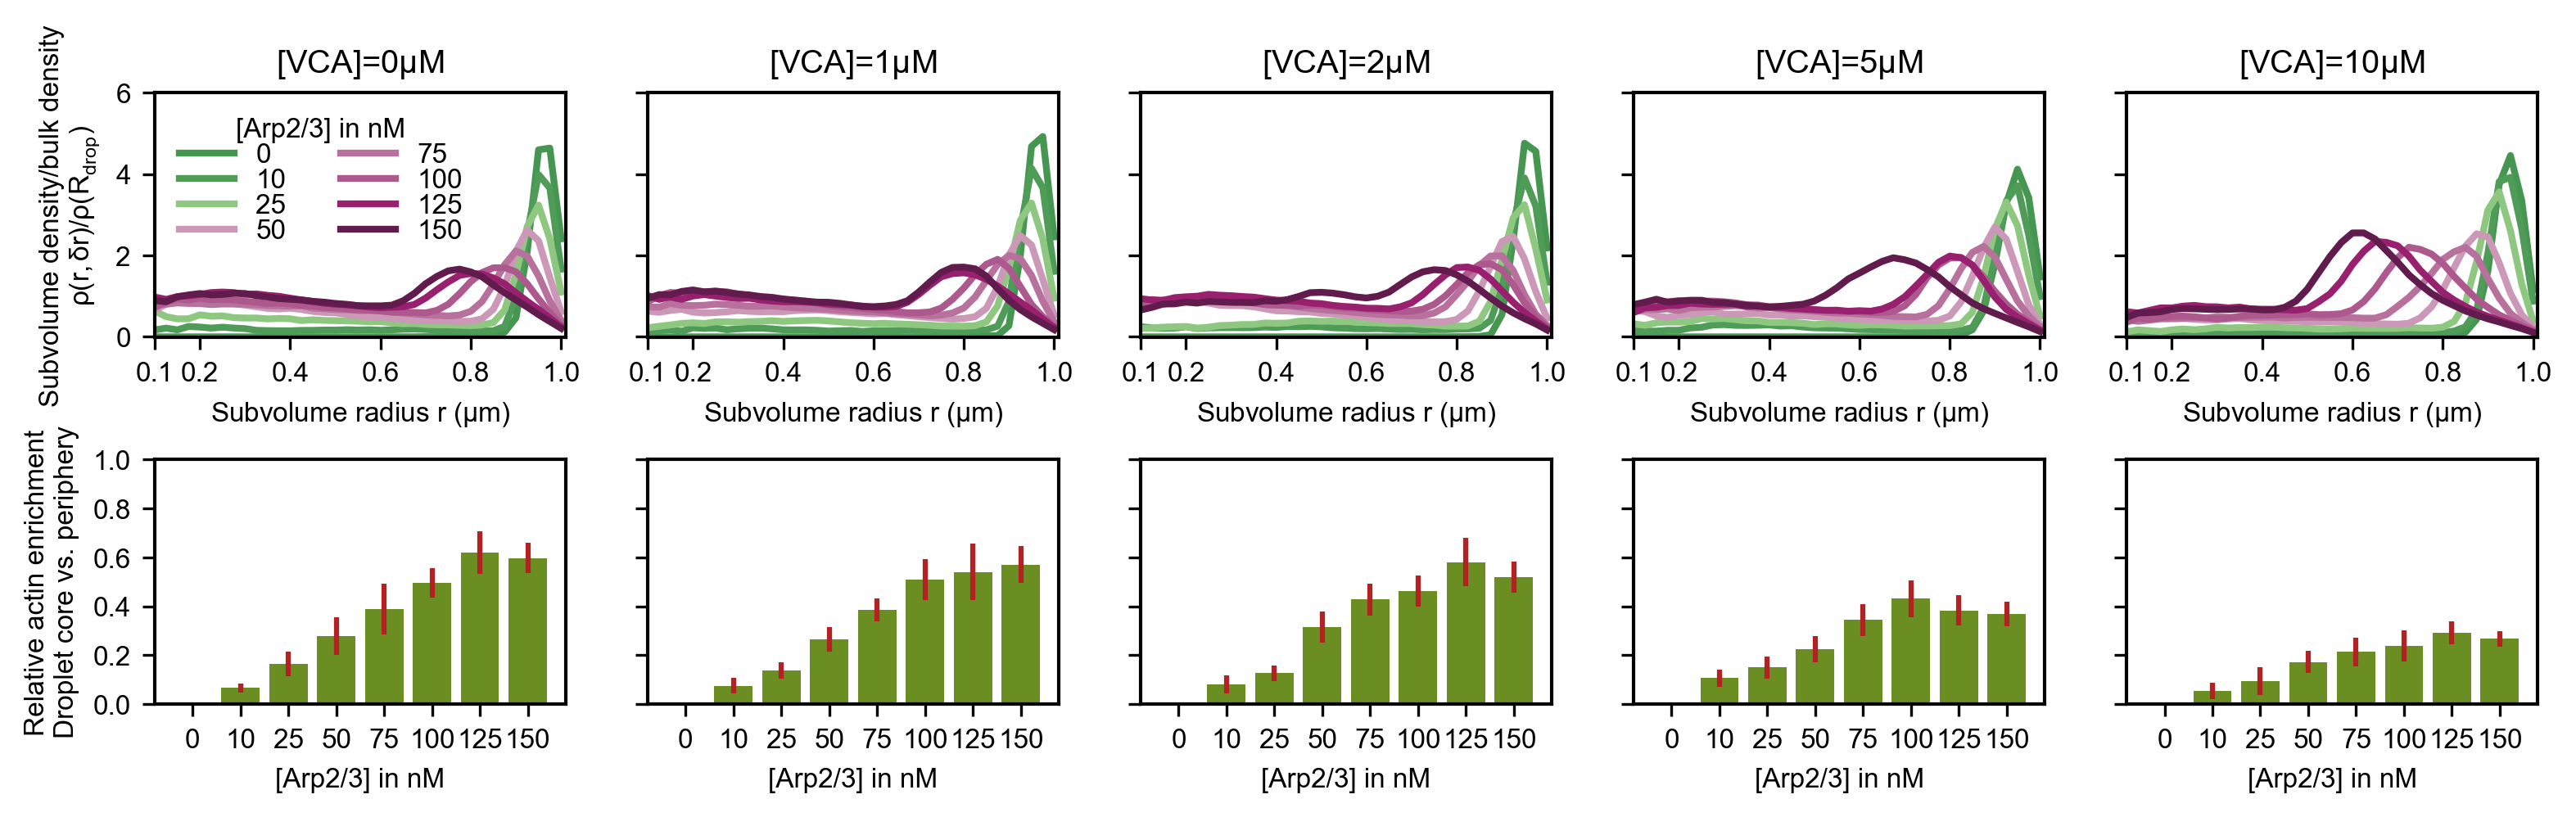

In [116]:
# Plot 1 - Just plot the final radial density
colorlist = ['#459651','#4E9C58','#8EC880','#CB98B7', '#B8709C','#AE598E','#991F6F','#621B4D']
rgba = new_cmap(np.linspace(0, int(256/7), 256))
plt.rcParams.update({'font.size': 8, 'font.family':'arial', 'font.weight'
                    :'normal'})
filepath = '/PATH-TO-FILE/outputfiles/'
nr = 2; nc = 5
fig, axvec = plt.subplots(nrows=nr, ncols=nc,figsize=(10,3.0), 
                          dpi=300, facecolor='w', edgecolor='k', sharex=False, sharey=False)
plt.subplots_adjust(left=0.01,
                    right=0.98,
                    bottom=0.05, 
                    top=0.88,
                    wspace=0.2, 
                    hspace=0.5)
VCAvec=[0,1,2,5,10];
Nreps =3
plotdf2 = pd.DataFrame()
plotdf2list = [];
Rvalmat = np.array([[0,5,10,15,20,25,30,35],[1,6,11,16,21,26,31,36],[2,7,12,17,22,27,32,37],[3,8,13,18,23,28,33,38],[4,9,14,19,24,29,34,39]])
for plotidx in range(0,5):
    legcell=[];
    for Riter, Rval in enumerate(Rvalmat[plotidx][:]):
        print([Rval, plotidx])
        Nveclist = []
        core_density_list = []
        peri_density_list = []
        relative_enrichment = []
        for repid in range(0,Nreps):
            filename = 'Density_VCA_Arp23_concsweep_steric_kunbind_0R_'+str(Rval)+'_r_'+str(repid)+'.csv'
            fvar = filepath + filename
            df = pd.read_csv(fvar,index_col=0)
            Nframes = len(df.columns)
            #get the radius vector
            radvec = df["Radius"]
            radvec = pd.concat([pd.Series([0]), radvec])
            dR = radvec.iat[1]-radvec.iat[0]
            for SREF in range(Nframes-10,Nframes):
                #Get the number count vector
                Nbin = df.iloc[:,SREF]
                ######### ORIGINAL VERSION
                # core_pos = int(len(Nbin)/4-1)
                # core_radius = radvec[core_pos]
                # core_density = Nbin[core_pos]/(core_radius*core_radius)
                # peri_pos = int(len(Nbin)-4)
                # peri_radius = radvec[peri_pos]
                # peri_density = Nbin[peri_pos]/(peri_radius*peri_radius)
                # core_density_list.append(core_density)
                # peri_density_list.append(peri_density)
                # relative_enrichment.append(core_density/peri_density)
                #########
                #Nvec = np.cumsum(Nbin)
                Nvec = Nbin
                Nvec = pd.concat([pd.Series([0]), Nvec])
                localfactor =dR**-1*radvec**-2
                #Nmax = Nvec.iat[-1]
                Nmax = np.sum(Nvec)
                Rmax = radvec.iat[-1]
                bulkfactor = 3*Nmax/(Rmax*Rmax*Rmax)
                density_ratio = Nvec*localfactor/bulkfactor
                density_ratio = density_ratio.fillna(0)
                Nveclist.append(density_ratio)
                ################# UPDATED VERSION
                rcutoff = 0.4
                radvec_core = radvec[(radvec>=0.2) & (radvec<rcutoff)]
                Ncore = Nvec[(radvec>=0.2) & (radvec<rcutoff)]
                radvec_periphery = radvec[(radvec>=rcutoff)]
                Nperiphery = Nvec[(radvec>=rcutoff)]
                maxNcore = Ncore.max()
                maxrcore = radvec_core[Ncore.idxmax()]
                maxNperiphery = Nperiphery.max()
                maxrperiphery = radvec_periphery[Nperiphery.idxmax()]
                core_density = maxNcore/(maxrcore*maxrcore)
                peri_density = maxNperiphery/(maxrperiphery*maxrperiphery)
                core_density_list.append(core_density)
                peri_density_list.append(peri_density)
                relative_enrichment.append(core_density/peri_density)
                #################
        plotdf2[Rval] = [np.mean(relative_enrichment), np.std(relative_enrichment)]
        # N(r)/r^2/N(R)/R^2
        plotdf = pd.DataFrame({'Radius':radvec,
                            'Density ratio':np.mean(Nveclist, axis=0),
                            'Std':np.std(Nveclist,axis=0),
                            'SEM':np.std(Nveclist,axis=0)/np.sqrt(Nreps)})
    #print(plotdf)
        # for x in range(0,len(Nveclist)):
        #     axvec[0].plot(plotdf['Radius'],Nveclist[x],linewidth=0.5,color=rgba[Rval,:])
        legax = axvec[0][plotidx].plot(plotdf['Radius'],plotdf['Density ratio'],linewidth=2,color=colorlist[Riter])
        legcell.append(legax[0])
        # axvec[0].fill_between(plotdf['Radius'],
        #                    plotdf['Density ratio']-plotdf['Std'],
        #                    plotdf['Density ratio']+plotdf['Std'],color=rgba[Rval,:],alpha=0.3)
        axvec[0][plotidx].set_xlabel(r"Subvolume radius r $(\mu m)$")
        axvec[0][plotidx].set_xticks([0,0.1,0.2,0.4,0.6,0.8,1.0])
        axvec[0][plotidx].set_ylim([-0.01,6])
        axvec[0][plotidx].set_xlim([0.1,1.01])
        axvec[0][plotidx].set_title(r'[VCA]='+str(VCAvec[plotidx])+'$\mu$M')
        if plotidx>0:
            axvec[0][plotidx].set_yticklabels([]);
            
        ##############
        #print([core_radius,peri_radius])
        if Rval>=35:
            plotdf2 = plotdf2.T
            plotdf2.columns = ['Mean','Std']
            axvec[1][plotidx].bar(np.arange(0,8),plotdf2['Mean'],color='olivedrab')
            axvec[1][plotidx].errorbar(np.arange(0,8),plotdf2['Mean'], yerr=plotdf2['Std'], fmt = 'o', markersize = 0, ecolor='firebrick')
            axvec[1][plotidx].set_xticks(np.arange(0,8))
            axvec[1][plotidx].set_xticklabels([0,10,25,50,75,100,125,150])
            axvec[1][plotidx].set_yticks([0,0.2,0.4,0.6,0.8,1.0,])
            if plotidx>0:
                axvec[1][plotidx].set_yticklabels([])
            axvec[1][plotidx].set_xlabel(r'[Arp2/3] in nM')
            plotdf2 = pd.DataFrame()
        #fig.tight_layout()
        # plt.savefig('Arp23_density.png', dpi=300, bbox_inches='tight')
        # fig.savefig( 'Arp23_density.pdf', bbox_inches='tight')
axvec[1][0].set_ylabel(r"Relative actin enrichment" "\n" "Droplet core vs. periphery")
axvec[0][0].legend(legcell,[0,10,25,50,75,100,125,150],ncol=2, title='[Arp2/3] in nM',frameon=False,labelspacing=0)
axvec[0][0].set_ylabel(r"Subvolume density/bulk density" "\n" r"$\rho(r, \delta r)/\rho(R_{drop})$")